#Imports

In [ ]:
from __future__ import annotations
from abc import ABC, abstractmethod
from dataclasses import dataclass, field
from typing import Optional, Dict, Any, List, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import jarque_bera, norm

from scipy import stats


#Handler base

El Handler es la clase base que define la lógica del patrón chain of responsibility. Sirve como esqueleto para que cada handler concreto implemente su propio método handle. Además, permite conectar un handler con otro usando set_next y pasar los datos de forma secuencial con _next_or_return. De esta manera se construye una cadena modular donde cada handler realiza una tarea específica sobre los datos.

In [ ]:
class Handler(ABC):
    """
    clase base para todos los handlers. define la estructura de la cadena de responsabilidades.

    inputs:
        - data: diccionario que contiene toda la información que se va pasando entre handlers

    qué hace:
        - permite encadenar varios handlers con set_next
        - obliga a que cada handler defina su propio método handle
        - cuando un handler termina, pasa los datos al siguiente con _next_or_return

    output:
        - devuelve data, ya sea procesado por el handler actual o por el último de la cadena
    """
    def __init__(self):
        #inicializo el siguiente handler en la cadena (si existe)
        self._next: Optional["Handler"] = None

    def set_next(self, handler: "Handler") -> "Handler":
        #defino cuál es el próximo handler en la cadena
        self._next = handler
        return handler

    @abstractmethod
    def handle(self, data):
        #este método lo tienen que implementar las subclases
        ...

    def _next_or_return(self, data):
        #si existe un siguiente handler se ejecuta, si no se devuelve data
        return self._next.handle(data) if self._next else data


#Descarga de datos

El DownloadDataHandler descarga los precios de cierre de los activos indicados y los factores de riesgo en la lista de tickers usando la librería yfinance. Primero valida que existan todos los parámetros necesarios en data, luego descarga las series de precios, las convierte a un DataFrame en caso de que solo se trate de un ticker, elimina filas vacías y finalmente guarda el DataFrame resultante en data["prices"]. De esta forma, deja listos los precios históricos para que otros handlers puedan utilizarlos en el pipeline.


In [ ]:

from dataclasses import dataclass
import pandas as pd
import yfinance as yf

@dataclass
class DownloadDataHandler(Handler):
  """
  descarga precios de cierre con yfinance y guarda en el diccionario data:

  inputs:
    - data["tickers"]       : lista de tickers de los activos del portafolio (ej: ["AAPL","MSFT"])
    - data["risk_factors"]  : lista de tickers de factores de riesgo (ej: ["^GSPC","TLT"])
    - data["period"]        : string con el período de descarga (ej: "5y", "1y", "max")
    - data["interval"]      : intervalo de observación (ej: "1d", "1wk", "1mo")

  qué hace:
    - descarga con yfinance las series de cierre ajustado de los activos y de los factores
    - elimina filas completamente vacías (dropna all)
    - deja las series en formato DataFrame, listas para posteriores cálculos

  outputs:
    - data["prices"]             : DataFrame con precios de cierre de los activos
    - data["risk_factor_prices"] : DataFrame con precios de cierre de los factores de riesgo
  """

  def handle(self, data: dict) -> dict:
    #extraigo parámetros desde el diccionario
    tickers      = data["tickers"]       # lista de activos del portafolio
    risk_factors = data["risk_factors"]  # lista de factores de riesgo
    period       = data["period"]        # período a descargar
    interval     = data["interval"]      # intervalo temporal

    #descargo precios de cierre de los activos del portafolio
    data["prices"] = (
        yf.download(tickers, period=period, interval=interval,
                    progress=False, auto_adjust=True)["Close"]
          .dropna(how="all")  #elimino filas donde todos son NaN
    )

    #descargo precios de cierre de los factores de riesgo
    data["risk_factor_prices"] = (
        yf.download(risk_factors, period=period, interval=interval,
                    progress=False, auto_adjust=True)["Close"]
          .dropna(how="all")
    )

    #paso los datos al siguiente handler o los devuelvo si no hay más
    return self._next_or_return(data)


#Valores pasados del Portfolio

PortfolioValueHandler calcula la evolución del valor de un portafolio a lo largo del tiempo. A partir de los precios de los activos y los pesos iniciales, determina cuántas acciones se pueden comprar en el inicio con el capital disponible. Manteniendo esas cantidades constantes, construye la serie del valor del portafolio multiplicando precios diarios por acciones. El resultado se guarda en data["portfolio_series"] y queda listo para los siguientes análisis.

In [ ]:
from dataclasses import dataclass
from typing import Dict, Any, List
import pandas as pd

@dataclass
class PortfolioValueHandler(Handler):
    """
    inputs:
      - data["tickers"] : lista de tickers
      - data["weights"] : lista de pesos (mismo orden que tickers)
      - data["prices"]  : DataFrame de precios (ajustados de preferencia)

    qué hace:
      - alinea precios entre tickers (intersección de fechas, dropna fila a fila)
      - usa el primer día común (t0) para calcular cantidades compradas con capital inicial
      - mantiene cantidades fijas y computa el valor diario del portafolio

    outputs:
      - data["portfolio_series"] : pd.Series con el valor del portafolio en el tiempo
      - data["portfolio_t0"]     : timestamp de la primera fecha común usada
      - data["portfolio_shares"] : pd.Series con cantidades por ticker
    """
    initial_capital = 100.0

    def handle(self, data: Dict[str, Any]) -> Dict[str, Any]:
        #inputs y chequeos básicos
        tickers = list(data["tickers"])
        weights = pd.Series(data["weights"], index=tickers, dtype=float)
        prices: pd.DataFrame = data["prices"].sort_index()

        #alineación: uso sólo fechas comunes entre todos los ticker
        px = prices[tickers].dropna(how="any")  #intersección estricta de fechas

        #t0 común y cantidades compradas
        t0 = px.index[0]
        p0 = px.loc[t0, tickers]
        shares = (self.initial_capital * weights) / p0

        #valor del portafolio en el tiempo
        port_series = (px * shares).sum(axis=1)
        port_series.name = "Valor del portafolio"

        #outputs
        data["portfolio_series"] = port_series
        data["portfolio_t0"] = t0
        data["portfolio_shares"] = shares

        return self._next_or_return(data)


#Retornos

Este handler transforma precios en retornos, que es el insumo principal para el análisis de riesgo. Primero ordena la serie temporal del portafolio y calcula manualmente los retornos diarios usando la fórmula de retorno simple:

$$
r_t = \frac{V_t}{V_{t-1}} - 1
$$

Después aplica el mismo procedimiento a los factores de riesgo, calculando retornos columna por columna de forma vectorizada. El resultado se guarda en data["portfolio_returns"] y data["risk_factor_returns"], listos para alimentar modelos como VaR, ETL o regresiones de factores.

In [ ]:

from dataclasses import dataclass
import numpy as np
import pandas as pd

@dataclass
class CalculatePortfolioReturns(Handler):
    """
    inputs:
      - data["portfolio_series"]: pd.Series con el valor del portafolio (buy&hold)
      - data["risk_factor_prices"]: pd.DataFrame con precios de los factores de riesgo

    qué hace:
      - ordena las series por fecha
      - calcula manualmente los retornos simples diarios del portafolio
      - calcula los retornos simples diarios de cada factor de riesgo

    outputs:
      - data["portfolio_returns"]: pd.Series con los retornos diarios del portafolio
      - data["risk_factor_returns"]: pd.DataFrame con los retornos diarios de factores de riesgo
    """
    def handle(self, data: dict) -> dict:
        #ordeno la serie del portafolio por fecha
        series = data["portfolio_series"].sort_index()
        #extraigo valores como array
        v = series.to_numpy(dtype=float)
        #calculo los retornos del portafolio
        r = v[1:] / v[:-1] - 1.0
        #armo la serie de retornos con índice alineado
        data["portfolio_returns"] = pd.Series(r, index=series.index[1:], name="portfolio")

        #ordeno precios de factores por fecha
        rf_prices = data["risk_factor_prices"].sort_index()
        #convierto precios de factores a array
        A = rf_prices.to_numpy(dtype=float)
        #calculo retornos diarios de factores
        R = A[1:, :] / A[:-1, :] - 1.0
        #armo dataframe de retornos de factores
        data["risk_factor_returns"] = pd.DataFrame(R, index=rf_prices.index[1:], columns=rf_prices.columns)

        #sigo la cadena
        return self._next_or_return(data)


#Estadisticas descriptivas

DescriptiveStatsHandler toma los retornos diarios del portafolio y calcula estadísticas descriptivas básicas como media, desvío estándar muestral, percentiles (1%, 5%, 50%, 95% y 99%), asimetría y curtosis. Con esto arma un diccionario y lo guarda en data["portfolio_stats"].

In [ ]:
@dataclass
class DescriptiveStatsHandler(Handler):
    """
    inputs:
      - data["portfolio_returns"]: pd.Series con los retornos diarios del portafolio

    qué hace:
      - calcula estadísticas descriptivas básicas (media, desvío estándar, percentiles, asimetría y curtosis)
      - resume la distribución de los retornos para usarla en análisis posteriores

    outputs:
      - data["portfolio_stats"]: dict con métricas descriptivas
    """

    def handle(self, data):
        #obtengo retornos del portafolio
        r = data["portfolio_returns"]

        #armo diccionario con estadísticas descriptivas
        out = {
            "count"    : r.count(),           #cantidad de datos
            "mean"     : r.mean(),            #media
            "std"      : r.std(ddof=1),       #desviación estándar muestral
            "var"      : r.var(ddof=1),      #varianza muestral
            "min"      : r.min(),             #mínimo
            "p1"       : r.quantile(0.01),    #percentil 1%
            "p5"       : r.quantile(0.05),    #percentil 5%
            "p50"      : r.median(),          #mediana (percentil 50%)
            "p95"      : r.quantile(0.95),    #percentil 95%
            "p99"      : r.quantile(0.99),    #percentil 99%
            "max"      : r.max(),             #máximo
            "skew"     : r.skew(),            #asimetría
            "kurtosis" : r.kurtosis(),        #curtosis
            "kurtosis_excess": r.kurtosis() - 3.0,  #curtosis en exceso
        }

        #printeo las estadisticas descriptivas
        print("\n===== Estadísticas descriptivas del portafolio =====")
        for k, v in out.items():
            print(f"{k:<20}: {v: .6f}")
        print("====================================================\n")

        #guardo resultado en data
        data["portfolio_stats"] = out

        #continúo cadena
        return self._next_or_return(data)


#Histograma

PlotReturnsHistogramHandler toma la serie de retornos diarios del portafolio y genera un histograma. Permite configurar la cantidad de bins y un título opcional. El gráfico muestra la frecuencia de los distintos niveles de retorno, ayudando a visualizar la distribución de los datos. No modifica el contenido de data, solo agrega el gráfico como salida visual.

In [ ]:
@dataclass
class PlotReturnsHistogramHandler(Handler):
    """
    inputs:
      - data["portfolio_returns"]: pd.Series con los retornos diarios del portafolio

    qué hace:
      - toma la serie de retornos y grafica un histograma
      - permite elegir cantidad de bins y un título opcional
      - muestra la distribución de los retornos de forma visual

    outputs:
      - no agrega nada nuevo a data, solo genera el gráfico
    """
    bins: int = 50
    title: Optional[str] = None

    def handle(self, data):
        #tomo la serie de retornos
        s = data["portfolio_returns"]

        #configuro figura y ploteo histograma
        plt.figure(figsize=(8, 4))
        plt.hist(s.values, bins=self.bins, edgecolor="k", alpha=0.7)

        #agrego títulos y etiquetas
        plt.title(self.title or "Histograma Retornos del Portafolio")
        plt.xlabel("Retorno diario")
        plt.ylabel("Frecuencia")
        plt.tight_layout()

        #muestro gráfico en pantalla
        plt.show()

        #sigo la cadena sin modificar data
        return self._next_or_return(data)

#Normalidad

NormalityHandler estandariza los retornos diarios del portafolio para que tengan media 0 y desvío estándar 1. Con esa serie construye un gráfico QQ-plot que compara los cuantiles de la muestra con los de una distribución normal estándar. Además aplica la prueba de Jarque-Bera para verificar la normalidad y guarda tanto los datos del gráfico como las estadísticas del test en data["normality"]. De esta forma permite evaluar de manera visual y estadística si los retornos siguen una distribución normal.

In [ ]:

@dataclass
class NormalityHandler(Handler):
    """
    inputs:
      - data["portfolio_returns"]: pd.Series con los retornos diarios del portafolio

    qué hace:
      - estandariza los retornos a media 0 y desvío 1
      - arma el qq-plot comparando la muestra con una normal estándar
      - calcula la prueba de normalidad Jarque-Bera
      - guarda resultados en data["normality"]

    outputs:
      - data["normality"]: dict con datos del qq-plot y resultados del test Jarque-Bera
    """

    def handle(self, data: Dict[str, Any]) -> Dict[str, Any]:
        #tomo retornos del portafolio
        r = data["portfolio_returns"]

        #estandarizo serie a media 0 y desvío 1
        s = (r - r.mean()) / r.std()

        #ordeno muestra y preparo cuantiles teóricos de la normal
        s_sorted = s.sort_values()
        n = len(s_sorted)
        i = np.arange(1, n + 1) #posiciones de los datos
        probs = (i - 0.5) / n #probabilidad de cada posicion
        q_theo = norm.ppf(probs) #cuantiles en base a la probabilidad

        #armo dataframe con pares de cuantiles
        qq_df = pd.DataFrame(
            {"theoretical": q_theo, "sample": s_sorted.values},
            index=s_sorted.index,
        )

        #calculo prueba jarque-bera
        jb_stat, jb_p = jarque_bera(s_sorted.values)

        # imprimir resultados del test de Jarque–Bera
        print("\n===== Test de Normalidad Jarque–Bera =====")
        print(f"Estadístico JB : {jb_stat:.4f}")
        print(f"p-valor        : {jb_p:.6f}")

        alpha = 0.05
        if jb_p < alpha:
            print("Conclusión     : Se rechaza H₀ — la distribución de retornos difiere significativamente de una Normal.")
        else:
            print("Conclusión     : No se rechaza H₀ — no hay evidencia estadísticamente significativa contra la normalidad.")
        print("===========================================\n")


        #guardo resultados en data
        data["normality"] = {
            "qq_data": qq_df,
            "jb_stat": float(jb_stat),
            "jb_pvalue": float(jb_p),
        }

        #ploteo qq-plot contra línea de referencia
        x = qq_df["theoretical"].values
        y = qq_df["sample"].values
        plt.figure(figsize=(6, 6))
        plt.scatter(x, y, s=12, alpha=0.8)
        lim_min = min(x.min(), y.min())
        lim_max = max(x.max(), y.max())
        plt.plot([lim_min, lim_max], [lim_min, lim_max], lw=1)
        plt.title("QQ-plot (retornos vs normal)")
        plt.xlabel("cuantil teórico normal")
        plt.ylabel("cuantil muestral retornos")
        plt.xlim(-3.5, 3.5)
        plt.ylim(-3.5, 3.5)
        plt.tight_layout()
        plt.show()

        #sigo cadena
        return self._next_or_return(data)


#EWMA

VolatilityEWMAHandler calcula la volatilidad condicional de los retornos del portafolio usando el modelo EWMA. Esto permite que la volatilidad vaya cambiando en el tiempo, en lugar de usar un único valor promedio que puede ser poco representativo. El handler además permite optimizar el parámetro λ (lambda) buscando cuál es el que mejor ajusta los datos, guardar la serie de volatilidad en el diccionario data y graficarla. Si se activa la opción de anualizar, también calcula la volatilidad en términos anuales.

Los tres helpers que usamos se conectan entre sí de forma sencilla:
- _ewma_variance: calcula la serie de varianzas condicionales con el modelo EWMA para un valor de λ dado.
- _mse_1step: mide el error de pronóstico de esas varianzas frente a los retornos reales, usando _ewma_variance.
- _select_lambda: prueba distintos valores de λ y elige el que da menor error, usando _mse_1step.

En resumen: _ewma_variance hace el cálculo base, _mse_1step evalúa qué tan bueno es ese cálculo y _select_lambda decide cuál λ es el más conveniente. Luego, con el λ elegido, el handler genera la serie de volatilidad, la guarda en data y la grafica.

In [ ]:

@dataclass
class VolatilityEWMAHandler(Handler):
    """
    inputs:
      - data["portfolio_returns"]: pd.Series con los retornos diarios del portafolio

    qué hace:
      - calcula la volatilidad condicional usando el modelo EWMA
      - permite optimizar el parámetro λ buscando el que minimiza el error de pronóstico
      - guarda la serie de volatilidad en data y genera un gráfico de σ_t
      - opcionalmente anualiza la volatilidad

    outputs:
      - data["sigma_series"]: pd.Series con la serie de volatilidad diaria
      - data["model_vol"]: dict con parámetros usados en el cálculo
      - data["sigma_annualized"]: pd.Series con volatilidad anualizada (si corresponde)
    """

    lam: float = 0.8
    optimize_lambda: bool = False
    lam_grid: Tuple[float, float, float] = (0.60, 0.99, 0.01)
    annualize: bool = False
    title: str = "EWMA σ_t (portafolio)"

    # ---------- helpers ----------
    @staticmethod
    def _ewma_variance(r: np.ndarray, lam: float) -> np.ndarray:
        #calculo varianza condicional con ewma
        if not (0.0 < lam < 1.0):
            raise ValueError("λ debe estar entre 0 y 1.")

        r2 = r**2
        n = r2.shape[0]
        var = np.empty(n, dtype=float)

        #inicializo con el primer retorno al cuadrado
        var[0] = float(r2[0])

        one_minus = 1.0 - lam
        for t in range(1, n):
            var[t] = one_minus * r2[t-1] + lam * var[t-1]

        return var

    def _mse_1step(self, r: np.ndarray, lam: float) -> float:
        #calculo mse de pronóstico a un paso
        var = self._ewma_variance(r, lam)
        r2 = r**2
        err = r2[1:] - var[1:]
        return float(np.mean(err * err))

    def _select_lambda(self, r: np.ndarray) -> float:
        #busco lambda óptimo en la grilla
        start, stop, step = self.lam_grid
        grid = np.arange(start, stop, step, dtype=float)
        mses = [self._mse_1step(r, lam) for lam in grid]
        best_idx = int(np.argmin(mses))
        return float(grid[best_idx])

    # -------------- handle principal ---------------
    def handle(self, data: Context) -> Context:
        #tomo retornos del portafolio
        r_series = data["portfolio_returns"]
        r = r_series.to_numpy(dtype=float)

        #selecciono lambda (fijo u optimizado)
        if self.optimize_lambda:
            lam_used = self._select_lambda(r)
            lam_opt = lam_used
            print("Lambda usado: ",lam_used)
        else:
            lam_used = float(self.lam)
            lam_opt = None

        #calculo varianza y paso a sigma
        var = self._ewma_variance(r, lam_used)
        sigma = np.sqrt(var)
        sigma_series = pd.Series(sigma, index=r_series.index, name="sigma_ewma")

        #guardo resultados en data
        data["sigma_series"] = sigma_series
        meta = {"model": "EWMA", "lambda": lam_used, "annualize": self.annualize}
        if lam_opt is not None:
            meta["lambda_opt"] = lam_opt
        data["model_vol"] = meta

        if self.annualize:
            data["sigma_annualized"] = sigma_series * np.sqrt(252.0)

        #ploteo volatilidad
        plt.figure(figsize=(10, 4.5))
        sigma_series.plot(linewidth=1.2, label="σ_t (diaria)")
        if self.annualize:
            data["sigma_annualized"].plot(linewidth=1.0, alpha=0.9, label="σ_t anualizada")
        plt.title(self.title)
        plt.xlabel("Fecha")
        plt.ylabel("Volatilidad")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

        return self._next_or_return(data)


#VaR Paramétrico

Este handler calcula el VaR paramétrico del portafolio. Primero usa el supuesto normal para obtener el VaR “clásico” y luego aplica la corrección de Cornish-Fisher para ajustar el cuantil según la asimetría y la curtosis de los retornos. Escala la volatilidad por el horizonte (raíz de días) y, si se activa use_mean, suma la media esperada en ese horizonte. Deja en data["var_param"] el VaR normal, el VaR corregido, los cuantiles usados y los momentos muestrales para poder comparar y reportar.

In [ ]:
@dataclass
class VaRParamHandler(Handler):
    """
    inputs:
      - data["portfolio_returns"]: pd.Series con retornos diarios del portafolio
      - data["sigma_series"]: pd.Series con volatilidad dinámica diaria (por ejemplo EWMA)

    qué hace:
      - calcula el VaR paramétrico asumiendo normalidad
      - ajusta el cuantil con Cornish-Fisher para considerar asimetría y curtosis
      - escala por horizonte en días y opcionalmente suma la media

    outputs:
      - data["var_param"]: dict con parámetros usados y VaR normal y Cornish-Fisher (en porcentaje del portafolio)
    """

    alpha: float = 0.01          #nivel de significancia (cola izquierda)
    horizon_days: int = 1        #horizonte en días
    use_mean: bool = False       #si es True, incluye μ*muestra*h

    def handle(self, data: dict) -> dict:
        #tomo retornos diarios y serie de volatilidad
        r: pd.Series = data["portfolio_returns"]
        sigma_series: pd.Series = data["sigma_series"]

        #tomo último sigma estimado
        sigma_last = float(sigma_series.iloc[-1])

        #calculo momentos muestrales
        skew = float(r.skew()) #asimetria
        kurt_excess = float(r.kurt())  #exceso de curtosis

        #armo parámetros básicos
        z = norm.ppf(self.alpha) #cuantil normal estándar
        sigma_h = np.sqrt(self.horizon_days) * sigma_last
        mu_h = float(self.horizon_days * r.mean()) if self.use_mean else 0.0

        #calculo var normal
        var_norm = -(mu_h + z * sigma_h)

        #corrijo cuantil con cornish-fisher (asimetría y curtosis)
        g1, g2 = skew, kurt_excess
        z_cf = (
            z
            + (1/6.0)*(z**2 - 1.0)*g1
            + (1/24.0)*(z**3 - 3.0*z)*g2
            - (1/36.0)*(2.0*z**3 - 5.0*z)*(g1**2)
        )
        var_cf = -(mu_h  + z_cf * sigma_h)

        #guardo resultados
        data["var_param"] = {
            "alpha": self.alpha,
            "h": self.horizon_days,
            "sigma_last": sigma_last,
            "mu": mu_h,
            "VaR_norm_pct": var_norm,
            "VaR_cf_pct": var_cf,
            "z": z,
            "z_cf": z_cf,
            "skew": skew,
            "kurt": kurt_excess,
        }

        #sigo cadena
        return self._next_or_return(data)


#VaR Histórico

Este handler estima el VaR histórico usando exclusivamente los retornos diarios del portafolio. Primero calcula el VaR empírico como el cuantil de cola y lo expresa como pérdida positiva. Después genera un intervalo de confianza percentílico con bootstrapping (remuestras con reemplazo, semilla fija para reproducibilidad). Finalmente, guarda en data["var_hist"] el VaR, el intervalo y los parámetros usados para poder reportar o comparar con otros métodos de riesgo.

In [ ]:

@dataclass
class VaRHistHandler(Handler):
    """
    inputs:
      - data["portfolio_returns"]: pd.Series con los retornos diarios del portafolio

    qué hace:
      - calcula el VaR histórico (no paramétrico) usando solo retornos diarios
      - arma un intervalo de confianza percentílico del VaR con bootstrapping
      - deja los resultados listos para reportar o comparar con otros métodos

    outputs:
      - data["var_hist"]: dict con VaR empírico, intervalo de confianza y parámetros usados
    """
    alpha: float = 0.01     #nivel de cola (ej. 1%)
    n_boot: int = 1000      #cantidad de remuestras bootstrap
    ci_level: float = 0.95  #nivel del intervalo de confianza

    # --- helper: distribución bootstrap del VaR histórico ---
    def _bootstrap_var(self, base: np.ndarray) -> np.ndarray:
        #fijo seed para reproducibilidad
        rng = np.random.default_rng(0)
        n = base.shape[0]
        out = np.empty(self.n_boot, dtype=float)
        for b in range(self.n_boot):
            #remuestro con reemplazo
            sample = base[rng.integers(0, n, size=n)]
            #calculo var de la remuestra (pérdida positiva)
            out[b] = -np.quantile(sample, self.alpha)
        return out

    # --- handle principal ---
    def handle(self, data: dict) -> dict:
        #tomo retornos diarios
        r: pd.Series = data["portfolio_returns"]
        base = r.to_numpy()

        #calculo var histórico puntual
        var_emp = -float(np.quantile(base, self.alpha))

        #hago bootstrap para el ic
        vars_boot = self._bootstrap_var(base)
        q_low = (1.0 - self.ci_level) / 2.0
        q_high = 1.0 - q_low
        ci_low, ci_high = np.quantile(vars_boot, [q_low, q_high])
        ci = (float(ci_low), float(ci_high))

        #guardo resultados en data
        data["var_hist"] = {
            "alpha": self.alpha,
            "VaR_emp_pct": var_emp,
            "ci": ci,
            "method": "historical_boot",
            "n_boot": self.n_boot,
        }
        #sigo cadena
        return self._next_or_return(data)



#ETL

El ETLHandler calcula dos medidas de riesgo basadas en retornos diarios: el VaR histórico y el ETL. Primero obtiene el cuantil de la cola izquierda al nivel alpha y lo reporta como pérdida positiva (VaR). Luego identifica todos los retornos que quedaron por debajo de ese umbral y calcula el ETL como el promedio de esas pérdidas extremas. Deja en data["etl"] tanto el VaR como el ETL, lo que permite complementar el análisis: el VaR dice hasta dónde puede llegar la pérdida con determinada probabilidad, mientras que el ETL muestra cuánto se pierde en promedio dentro de esos escenarios extremos.

In [ ]:

@dataclass
class ETLHandler(Handler):
    """
    inputs:
      - data["portfolio_returns"]: pd.Series con los retornos diarios del portafolio
      - data["portfolio_series"]: pd.Series con el valor monetario del portafolio
      - data["var_hist"]["VaR_emp_pct"]: VaR histórico ya calculado (en %)

    qué hace:
      - toma el VaR histórico en % como umbral de la cola
      - identifica los retornos que caen por debajo de ese nivel
      - calcula el ETL porcentual como el promedio de esas pérdidas extremas
      - convierte ese ETL porcentual a monto monetario usando el valor actual del portafolio

    outputs:
      - data["etl"]: dict con ETL porcentual, ETL monetario, VaR y nivel alpha
    """
    alpha: float = 0.01  #nivel de cola

    def handle(self, data: dict) -> dict:
        #tomo retornos diarios
        r: pd.Series = data["portfolio_returns"]

        #tomo var histórico ya calculado (%)
        var_emp_pct: float = data["var_hist"]["VaR_emp_pct"]

        #tomo serie de valores del portafolio
        port_series: pd.Series = data["portfolio_series"]

        #defino umbral en términos de retorno
        q_alpha = -var_emp_pct

        #filtro cola de retornos bajo el umbral
        tail = r[r <= q_alpha]

        #calculo etl porcentual
        etl_pct = -float(tail.mean())

        #calculo etl monetario usando el último valor del portafolio
        last_value = float(port_series.iloc[-1])
        etl_monetary = etl_pct * last_value

        #guardo resultados en data
        data["etl"] = {
            "alpha": self.alpha,
            "ETL_pct": etl_pct,
            "ETL_monetary": etl_monetary,
        }

        #sigo cadena
        return self._next_or_return(data)


#Clustering (K-means y KNN)

Este handler clasifica la volatilidad diaria σ_t en estados usando k-means en una dimensión y ordena los clusters de menor a mayor nivel de volatilidad. Luego aplica un suavizado KNN por moda local en una ventana corta para reducir “saltos” espurios en las etiquetas. Opcionalmente puede optimizar k maximizando el silhouette promedio en 1D. Deja cuatro salidas clave en data: las etiquetas crudas (clusters), las suavizadas (clusters_knn), el k_used y los centroids ordenados. También genera un gráfico con la asignación original y la versión suavizada para comparar visualmente.


ME PARECE QUE LA OPTIMIZACION DE K ESTÁ ANDANDO MAL, TESTEAR (supuestamente lo arregle)

In [ ]:

from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

@dataclass
class VolatilityClusteringHandler(Handler):
    """
    inputs:
      - data["sigma_series"]: pd.Series con la volatilidad diaria (σ_t) del portafolio

    qué hace:
      - aplico k-means sobre σ_t para clasificar estados de volatilidad
      - opcionalmente optimizo k maximizando el silhouette promedio
      - suavizo las etiquetas con un KNN por moda local para reducir saltos
      - ordeno los clusters por nivel (0=baja, 1=media, ...) y grafico resultados

    outputs:
      - data["clusters"]: pd.Series con etiquetas k-means ordenadas por nivel
      - data["clusters_knn"]: pd.Series con etiquetas suavizadas por moda local
      - data["k_used"]: int con el número final de clusters
      - data["centroids"]: np.ndarray con los centroides ordenados (baja→alta)
    """
    k: int = 3
    max_iter: int = 100
    optimize_k: bool = False
    k_min: int = 2
    k_max: int = 6

    # K-means
    def _kmeans_1d(self, x: np.ndarray, k: int) -> tuple[np.ndarray, np.ndarray]:
        #limpio a 1d y reshaped
        x1d = np.asarray(x, dtype=float).ravel()
        X = x1d[:, None]

        #inicializo centroides con cuantiles equiespaciados
        qs = np.linspace(10, 90, k)
        centroids = np.nanpercentile(x1d, qs).astype(float).reshape(-1, 1)

        tol = 1e-8
        for _ in range(self.max_iter):
            #asigno cada punto al centroide más cercano
            dists = np.abs(X - centroids.T)
            labels = np.argmin(dists, axis=1)

            #actualizo centroides como medias por grupo
            new_centroids = []
            for j in range(k):
                group = X[labels == j]
                new_centroids.append(np.array([group.mean()]))
            new_centroids = np.vstack(new_centroids)

            #chequeo convergencia
            if np.linalg.norm(new_centroids - centroids) < tol:
                centroids = new_centroids
                break
            centroids = new_centroids

        #ordeno clusters por nivel (0=baja,...)
        centroids = centroids.flatten() # [0.042, 0.011, 0.027]
        order = np.argsort(centroids) # [1, 2, 0]
        remap = {old: new for new, old in enumerate(order)} # {0:1, 1:2, 2:0} --> {1:0, 2:1, 0:2}
        labels_ord = np.array([remap[l] for l in labels])
        centroids_ord = np.sort(centroids)
        return labels_ord, centroids_ord

    # --- Silhouette promedio para clustering (distancia absoluta) ---
    def _silhouette_1d(self, x: np.ndarray, labels: np.ndarray, k: int) -> float:
        #calculo silhouette 1d
        x1d = np.asarray(x, dtype=float).ravel()
        n = x1d.shape[0]
        s = np.zeros(n, dtype=float)

        for i in range(n):
            li = labels[i]
            same = (labels == li)
            same_idx = np.where(same)[0]

            #manejo cluster unitario
            if same_idx.size <= 1:
                s[i] = 0.0
                continue

            #calculo a(i) = distancia media a los puntos de su mismo cluster
            a = np.mean(np.abs(x1d[i] - x1d[same_idx[same_idx != i]]))

            #calculo b(i) = distancia media a los puntos de cualquier otro cluster (el mas cercano)
            b = np.inf
            for cj in range(k):
                if cj == li:
                    continue
                idx = np.where(labels == cj)[0]
                if idx.size > 0:
                    b = min(b, np.mean(np.abs(x1d[i] - x1d[idx])))

            #normalizo
            m = max(a, b)
            s[i] = 0.0 if (m <= 0 or not np.isfinite(m)) else (b - a) / m

        return float(np.mean(s))

    # --- KNN por moda local (ventana 5: t-2..t+2) ---
    def _knn_smooth_mode(self, labels: np.ndarray, win_half: int = 2) -> np.ndarray:
        #suavizo etiquetas por moda local
        smoothed = labels.copy()
        n = labels.shape[0]
        for i in range(n):
            left = max(0, i - win_half)
            right = min(n, i + win_half + 1)
            window = labels[left:right]
            modes = pd.Series(window).mode()
            if len(modes) == 1:
                smoothed[i] = modes.iloc[0]
            else:
                #rompo empate favoreciendo la etiqueta central
                center = labels[i]
                smoothed[i] = center if center in modes.values else modes.iloc[0]
        return smoothed

    # --- Selección de k por silhouette ---
    def _select_k(self, x: np.ndarray) -> tuple[int, np.ndarray, np.ndarray, float]:
        #busco k óptimo maximizando silhouette
        x1d = np.asarray(x, dtype=float).ravel()
        best_k, best_labels, best_centroids, best_score = None, None, None, -np.inf
        for k in range(self.k_min, self.k_max + 1):
            labels, cents = self._kmeans_1d(x1d, k)
            score = self._silhouette_1d(x1d, labels, k)
            if score > best_score:
                best_k, best_labels, best_centroids, best_score = k, labels, cents, score
        return best_k, best_labels, best_centroids, best_score

    # --- handle principal ---
    def handle(self, data: dict) -> dict:
        # tomo σ_t directamente (sin chequeos de NaN)
        sigma: pd.Series = data["sigma_series"]
        x = sigma.values.astype(float)

        # elijo k y etiqueto
        if self.optimize_k:
            k_used, labels, cents, _ = self._select_k(x)
        else:
            k_used = self.k
            labels, cents = self._kmeans_1d(x, k_used)

        # suavizo con knn por moda local
        labels_knn = self._knn_smooth_mode(labels, win_half=2)

        # reconstruyo series alineadas al índice original
        clusters = pd.Series(labels, index=sigma.index, dtype="Int64")
        clusters_knn = pd.Series(labels_knn, index=sigma.index, dtype="Int64")


        #guardo salidas
        data["clusters"] = clusters
        data["clusters_knn"] = clusters_knn
        data["k_used"] = int(k_used)
        data["centroids"] = np.array(cents, dtype=float)

        #grafico resultados
        fig, axes = plt.subplots(3, 1, figsize=(11, 9), sharex=True)
        cmap = plt.get_cmap("tab10")

        #primer panel: clusters originales de k-means
        axes[0].set_title(f"K-means σ_t (k={k_used})")
        for c in range(k_used):
            #marco los puntos de cada cluster en distinto color
            mask = (clusters == c)
            axes[0].scatter(sigma.index[mask], sigma[mask], s=8, color=cmap(c), label=f"cluster {c}", alpha=0.9)
        #superpongo la serie original en gris para ver la trayectoria completa
        axes[0].plot(sigma.index, sigma.values, lw=0.8, color="gray", alpha=0.5)
        #agrego leyenda con los clusters
        axes[0].legend(loc="upper left", ncols=min(k_used, 4), fontsize=8)
        axes[0].set_ylabel("σ")

        #segundo panel: clusters suavizados con knn
        axes[1].set_title("Clusters suavizados (KNN, ventana=5)")
        for c in range(k_used):
            #marco los puntos suavizados de cada cluster
            mask2 = (clusters_knn == c)
            axes[1].scatter(sigma.index[mask2], sigma[mask2], s=8, color=cmap(c), label=f"cluster {c}", alpha=0.9)
        #superpongo la serie original para comparar
        axes[1].plot(sigma.index, sigma.values, lw=0.8, color="gray", alpha=0.5)
        #agrego leyenda con clusters suavizados
        axes[1].legend(loc="upper left", ncols=min(k_used, 4), fontsize=8)
        axes[1].set_ylabel("σ")

        #tercer panel: retornos del portafolio
        axes[2].set_title("Retornos del portafolio")
        if "portfolio_returns" in data:
            r_port = data["portfolio_returns"]
            #dibujo línea horizontal en cero
            axes[2].axhline(0.0, lw=0.8, color="black", alpha=0.4)
            #grafico los retornos del portafolio
            axes[2].plot(r_port.index, r_port.values, lw=0.8, color="black", alpha=0.8)
            axes[2].set_ylabel("r_t")
        else:
            #muestro mensaje si los retornos no están disponibles
            axes[2].text(0.5, 0.5, "portfolio_returns no disponible",
                         transform=axes[2].transAxes, ha="center", va="center", fontsize=10)
            axes[2].set_ylabel("r_t")
        axes[2].set_xlabel("Fecha")


        plt.tight_layout()
        plt.show()

        #sigo cadena
        return self._next_or_return(data)



#Markov

Este handler construye la matriz de transición
P usando la secuencia de estados suavizados clusters_knn. Primero ordeno las etiquetas por fecha, cuento las transiciones entre días consecutivos (origen
𝑡 → destino
𝑡
+
1
) y normalizo por filas para obtener probabilidades. Guardo los conteos, la matriz
𝑃 y metadatos útiles (cantidad de estados, suma por filas, total de transiciones, estado inicial/final), y finalmente muestro un heatmap de
𝑃
 para visualizar rápidamente qué transiciones son más probables. Esto deja lista la parte de cadenas de Markov que uso luego en simulaciones y escenarios.



In [ ]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

@dataclass
class MarkovHandler(Handler):
    """
    inputs:
      - data["clusters_knn"]: pd.Series con etiquetas de estado 0..K-1 (índice temporal)

    qué hace:
      - construyo la matriz de transición P a partir de pares consecutivos (t → t+1)
      - normalizo por filas para obtener probabilidades
      - guardo conteos, matriz P y metadatos; además grafico un heatmap de P

    outputs:
      - data["markov_counts"]: np.ndarray con conteos de transiciones i→j
      - data["markov_P"]: np.ndarray con matriz de transición fila-estocástica
      - data["markov_meta"]: dict con K, estados, suma por filas, cantidad de transiciones y estados inicial/final
    """
    title: str = "Matriz de transición (P)"
    figsize: tuple[float, float] | None = None
    cmap: str = "coolwarm"
    annotate: bool = True
    decimals: int = 2  # ahora con dos decimales para el porcentaje

    def __post_init__(self):
        #inicializo base Handler (compatibilidad con dataclass)
        Handler.__init__(self)

    def _plot_P(self, P: np.ndarray, states: list[int]) -> None:
        #calculo tamaño de figura según K si no lo paso
        K = len(states)
        side = max(4.0, min(1.2 * K, 14.0)) if self.figsize is None else None
        figsize = (side, side) if self.figsize is None else self.figsize

        #armo heatmap de P
        fig, ax = plt.subplots(figsize=figsize)
        im = ax.imshow(P, cmap=self.cmap, vmin=0.0, vmax=1.0, origin="upper", interpolation="nearest")

        #configuro ejes y rótulos
        ax.set_xticks(np.arange(K)); ax.set_yticks(np.arange(K))
        ax.set_xticklabels(states);  ax.set_yticklabels(states)
        ax.set_xlabel("Estado t+1 (destino)"); ax.set_ylabel("Estado t (origen)")
        ax.set_title(self.title)

        #agrego grilla menor
        ax.set_xticks(np.arange(-.5, K, 1), minor=True)
        ax.set_yticks(np.arange(-.5, K, 1), minor=True)
        ax.grid(which="minor", color="white", linewidth=0.8, alpha=0.6)
        ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

        #anoto valores si lo permito y K no es grande
        if self.annotate and (K <= 15):
            fmt = "{:0." + str(self.decimals) + "f}%"
            for i in range(K):
                for j in range(K):
                    ax.text(j, i, fmt.format(100 * P[i, j]), ha="center", va="center", fontsize=9)

        #agrego colorbar y muestro
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Prob. de transición (%)", rotation=90)
        plt.tight_layout(); plt.show()

    def handle(self, data: dict) -> dict:
        #tomo etiquetas y ordeno por fecha; saco nulos y paso a int
        s: pd.Series = data["clusters_knn"]
        s = s.sort_index().dropna().astype(int)

        #armo lista de estados distintos y su cantidad
        states = sorted(pd.unique(s))
        K = len(states)

        #armo pares origen→destino (t y t+1)
        from_states = s.iloc[:-1].to_numpy()  #tomo todos menos el último
        to_states   = s.iloc[1:].to_numpy()   #tomo todos menos el primero

        #cuento transiciones i→j y reordeno a la grilla de 'states'
        counts_df = pd.crosstab(from_states, to_states, dropna=False)
        counts_df = counts_df.reindex(index=states, columns=states, fill_value=0)
        counts = counts_df.to_numpy(dtype=int)

        #calculo totales por fila (estado origen)
        row_sums = counts.sum(axis=1, keepdims=True)

        #normalizo a probabilidades por fila
        P = np.zeros((K, K), dtype=float)
        for i in range(K):
            total = row_sums[i, 0]
            if total > 0:
                for j in range(K):
                    P[i, j] = counts[i, j] / total
        #si total==0, dejo fila en ceros (estado sin salidas observadas)

        #guardo resultados y metadatos
        data["markov_counts"] = counts
        data["markov_P"] = P
        data["markov_meta"] = {
            "K": K,
            "states": states,
            "row_sums": P.sum(axis=1).round(12).tolist(),
            "n_transitions": int(counts.sum()),
            "state_first": int(s.iloc[0]),
            "state_last": int(s.iloc[-1]),
            "plot_title": self.title,
        }

        #muestro heatmap
        self._plot_P(P, states)

        #sigo cadena
        return self._next_or_return(data)

#VaR Simulado

Este handler estima el VaR por simulación condicionada a estados de volatilidad. Primero construyo los parámetros por estado: tomo σ de los centroides del clustering y calculo μ por estado con un t-test contra 0; si la media no es significativa, la dejo en 0 para no sesgar. Luego simulo trayectorias de estados usando la matriz de transición de Markov y, dado cada estado, simulo retornos normales con sus μ y σ. Con esos retornos compongo
𝑅ℎ a h días, armo la distribución y tomo el cuantil de cola para obtener el VaR simulado al nivel alpha. Puedo arrancar las simulaciones todas en el último estado, en un estado forzado o balanceadas entre todos. El resultado se guarda en data["simu_paths"] y data["var_simu"] para análisis y gráficos posteriores.

In [ ]:

from dataclasses import dataclass
import numpy as np
import pandas as pd
from scipy import stats  # necesito stats para el t-test por estado

@dataclass
class SimuVaRHandler(Handler):
    """
    inputs:
      - data["markov_P"]: np.ndarray con la matriz de transición entre estados (fila-estocástica)
      - data["clusters_knn"]: pd.Series con estados suavizados (0..K-1)
      - data["centroids"]: np.ndarray con σ por estado (ordenados baja→alta)
      - data["portfolio_returns"]: pd.Series con retornos diarios del portafolio

    qué hace:
      - construyo μ y σ por estado (μ por t-test: si p<alpha_sig uso la media; si no, pongo 0)
      - simulo trayectorias de estados con la cadena de Markov y retornos ~ N(μ_state, σ_state)
      - compongo retornos a h días, armo la distribución y calculo VaR simulado al nivel alpha
      - elijo estados iniciales según start_mode: balanced, last u override

    outputs:
      - data["simu_paths"]: dict con matrices de estados, retornos, R_h y vector de estados iniciales
      - data["var_simu"]: dict con VaR simulado (porcentaje), horizonte y método
      - data["mean_test_by_state"]: dict con diagnóstico del t-test por estado
    """
    n_sims: int = 10_000
    horizon_days: int = 20
    alpha: float = 0.01
    alpha_sig: float = 0.05        # umbral p-value para decidir si usar μ
    start_mode: str = "balanced"   # 'balanced' | 'last' | 'override'
    start_state_override: int | None = None

    def __post_init__(self):
        #inicializo base Handler (compatibilidad con dataclass)
        Handler.__init__(self)

    # --- helpers ---

    def _mu_por_estado(self, data: dict, clusters: pd.Series, K: int) -> np.ndarray:
        """
        calculo μ por estado con t-test bilateral H0: μ_k = 0.
        si p < alpha_sig, uso la media muestral de r_k; si no, seteo 0.
        """
        #tomo retornos y alineo con estados
        r = data["portfolio_returns"].dropna()
        aligned = pd.concat({"state": clusters, "r": r}, axis=1).dropna()

        mu_vec = np.zeros(K, dtype=float)
        diag = {}

        #recorro estados y hago t-test 1 muestra contra 0
        for k in range(K):
            rk = aligned.loc[aligned["state"] == k, "r"].to_numpy()
            if rk.size >= 2:
                t_stat, p_val = stats.ttest_1samp(rk, popmean=0.0, alternative="two-sided")
                mean_k = float(rk.mean())
                #decido si uso la media según significancia
                mu_vec[k] = mean_k if (p_val < self.alpha_sig) else 0.0
                diag[k] = {"n": int(rk.size), "mean": mean_k, "t": float(t_stat), "p": float(p_val)}
            else:
                #manejo caso con pocos datos
                mu_vec[k] = 0.0
                diag[k] = {"n": int(rk.size), "mean": float(rk.mean()) if rk.size else np.nan, "t": np.nan, "p": np.nan}

        #guardo diagnóstico del t-test por estado
        data["mean_test_by_state"] = diag
        return mu_vec

    def _simular_estados(self, P: np.ndarray, s0: int, h: int, rng: np.random.Generator) -> np.ndarray:
        #simulo cadena de estados de longitud h
        K = P.shape[0]
        states = np.empty(h, dtype=int)
        current = int(s0)
        for t in range(h):
            current = rng.choice(K, p=P[current])
            states[t] = current
        return states

    def _simular_retorno_path(self, states: np.ndarray, mu: np.ndarray, sigma: np.ndarray,
                              rng: np.random.Generator) -> np.ndarray:
        #simulo retornos condicionales por estado ~ N(μ_state, σ_state)
        return rng.normal(loc=mu[states], scale=sigma[states], size=states.shape[0])

    # --- handle principal ---
    def handle(self, data: dict) -> dict:
        #tomo insumos de markov, estados y dimensión
        P = np.asarray(data["markov_P"], dtype=float)
        clusters: pd.Series = data["clusters_knn"].dropna().astype(int)
        K = P.shape[0]

        #armo σ por estado desde centroides (protejo contra 0)
        sigma_states = np.maximum(np.array(data["centroids"], dtype=float).squeeze(), 1e-12)
        #armo μ por estado con t-test
        mu_states = self._mu_por_estado(data, clusters, K)

        #defino estados iniciales de cada simulación
        last_state = int(clusters.iloc[-1])
        if self.start_mode == "override":
            #inicio todas en el estado indicado
            s0_vec = np.full(self.n_sims, int(self.start_state_override), dtype=int)
        elif self.start_mode == "balanced":
            #reparto simulaciones lo más parejo posible entre 0..K-1
            base = self.n_sims // K
            rem = self.n_sims - base * K
            s0_vec = np.concatenate([np.full(base, k, dtype=int) for k in range(K)])
            if rem > 0:
                s0_vec = np.concatenate([s0_vec, np.arange(rem, dtype=int)])
        else:  # 'last'
            #inicio todas en el último estado observado
            s0_vec = np.full(self.n_sims, last_state, dtype=int)

        #simulo estados y retornos condicionales
        h, n = int(self.horizon_days), int(self.n_sims)
        rng = np.random.default_rng(0)  #fijo seed
        states_mat = np.empty((n, h), dtype=int)
        returns_mat = np.empty((n, h), dtype=float)
        for i in range(n):
            st = self._simular_estados(P, int(s0_vec[i]), h, rng)
            states_mat[i, :] = st
            returns_mat[i, :] = self._simular_retorno_path(st, mu_states, sigma_states, rng)

        #compongo retornos a h días y calculo var simulado (pérdida positiva)
        R_h = (1.0 + returns_mat).prod(axis=1) - 1.0
        var_sim = -float(np.quantile(R_h, self.alpha))
        if var_sim < 0:
            #me aseguro de reportar magnitud positiva
            var_sim = -var_sim

        #guardo salidas
        data["simu_paths"] = {"states": states_mat, "returns": returns_mat, "R_h": R_h, "s0": s0_vec}
        data["var_simu"] = {"alpha": float(self.alpha), "h": h, "VaR_sim_pct": var_sim, "method": "markov_normal_cond"}

        #sigo cadena
        return self._next_or_return(data)

#Significancia de la media

Este handler evalúa si la media de los retornos es distinta de cero usando un t-test bilateral de una muestra. Primero calcula el resultado global con todos los retornos y, si existen etiquetas de estado (clusters_knn), repite el t-test dentro de cada estado alineando por fecha. Guarda en data["mean_test"] los estadísticos clave (t, p, n, media y desvío) globales y por estado, e imprime un resumen indicando si la media resulta “significativa” o “no significativa” al nivel alpha. Esto sirve para decidir si conviene usar una media distinta de cero en simulaciones o modelos posteriores.

In [ ]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
from scipy import stats

@dataclass
class MeanSignificanceTestHandler(Handler):
    """
    inputs:
      - data["portfolio_returns"]: pd.Series con retornos diarios del portafolio
      - data["clusters_knn"] (opcional): pd.Series con etiquetas de estado 0..K-1

    qué hace:
      - corre un t-test bilateral de una muestra contra 0 para la media global
      - si hay clusters_knn, repite el t-test por cada estado (alineando por fecha)
      - arma un dict con t, p, n, media y desvío estándar (global y por estado)

    outputs:
      - data["mean_test"]: dict con resultados globales y por estado (si existen)
      - además imprime siempre un resumen legible con el rótulo de significancia
    """
    alpha: float = 0.01  # umbral p-value para rotular "significativa / no significativa"

    # --- helper: t-test 1 muestra contra 0 ---
    def _one_sample_ttest(self, x: pd.Series) -> dict:
        #limpio nulos y preparo serie
        x = pd.Series(x).dropna()
        #ejecuto t-test bilateral contra 0
        t_stat, p_val = stats.ttest_1samp(x, popmean=0.0, alternative="two-sided", nan_policy="omit")
        #armo salida con estadísticos principales
        return {
            "t_stat": float(t_stat),
            "p_value": float(p_val),
            "n": int(x.shape[0]),
            "mean": float(x.mean()),
            "std": float(x.std(ddof=1)),
        }

    def _sig_label(self, p: float) -> str:
        #rotulo significancia según alpha
        return f"significativa (p < {self.alpha:.2f})" if p < self.alpha else f"no significativa (p ≥ {self.alpha:.2f})"

    # --- handle principal ---
    def handle(self, data: dict) -> dict:
        #tomo retornos del portafolio
        r: pd.Series = data["portfolio_returns"]

        #corro test global
        res_global = self._one_sample_ttest(r)

        #corro test por estado si hay clusters_knn
        by_state = {}
        lab = data["clusters_knn"].reindex(r.index)
        for k in sorted(pd.unique(lab.dropna().astype(int))):
            #filtrado por estado k y t-test
            by_state[int(k)] = self._one_sample_ttest(r[lab == k])

        #armo salida y guardo en data
        out = {
            "t_stat": res_global["t_stat"],
            "p_value": res_global["p_value"],
            "n": res_global["n"],
            "mean": res_global["mean"],
            "std": res_global["std"],
            "by_state": by_state
        }
        data["mean_test"] = out

        #imprimo resumen legible
        print("\n# Prueba de significancia de la media")
        print(f"- global: n={out['n']}, mean={out['mean']:.6f}, std={out['std']:.6f}, "
              f"t={out['t_stat']:.3f}, p={out['p_value']:.4f} -> {self._sig_label(out['p_value'])}")
        if by_state:
            print("- por estado (clusters_knn):")
            for k in sorted(by_state):
                rs = by_state[k]
                print(f"  · estado {k}: n={rs['n']}, mean={rs['mean']:.6f}, std={rs['std']:.6f}, "
                      f"t={rs['t_stat']:.3f}, p={rs['p_value']:.4f} -> {self._sig_label(rs['p_value'])}")

        #sigo cadena
        return self._next_or_return(data)


#Grafico de distribuciones por estado

Este handler compara cómo luce la distribución de
𝑅ℎ según el estado inicial de cada simulación. Para cada estado de partida, dibuja un histograma de densidad de los retornos compuestos a h días y, además, imprime un resumen con cantidad de simulaciones, media, desvío y el VaR al nivel alpha calculado dentro de ese subconjunto. No altera el data: solo produce el gráfico y el resumen para diagnosticar si arrancar en distintos estados cambia de forma relevante el perfil de pérdidas.

In [ ]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew

@dataclass
class PlotSimuByStartStateHandler(Handler):
    """
    inputs:
      - data["simu_paths"]: dict con resultados de simulación
        · "states": np.ndarray (n_sims, h) con estados simulados por paso
        · "R_h": np.ndarray (n_sims,) con retornos acumulados a h días

    qué hace:
      - grafico las distribuciones simuladas de R_h separadas por estado inicial
      - muestro histogramas de densidad por cada estado inicial
      - imprimo un resumen por estado inicial con n, media, desvío y VaR al nivel alpha

    outputs:
      - no modifica data; genera gráficos y un resumen por consola
    """

    def __post_init__(self):
        #inicializo base Handler (compatibilidad con dataclass)
        Handler.__init__(self)

    alpha: float = 0.01
    bins: int = 60
    title: str = r"Distribuciones simuladas de $R_h$ por estado inicial"

    def handle(self, data: dict) -> dict:
        #tomo paths simulados
        paths = data["simu_paths"]
        #extraigo matriz de estados y retornos compuestos
        states = paths["states"]            # (n_sims, h)
        R_h = paths["R_h"]                  # (n_sims,)
        #identifico estado inicial de cada simulación
        s0 = paths["s0"]
        #obtengo lista de estados presentes
        ks = np.unique(s0)

        #ploteo histogramas por estado inicial
        plt.figure(figsize=(10, 6))
        for k in ks:
            #filtro simulaciones que arrancan en el estado k
            mask = (s0 == k)
            #dibujo histograma de densidad de R_h para el estado k
            plt.hist(R_h[mask], bins=self.bins, density=True, alpha=0.35, label=f"ini: {int(k)}")
        #configuro títulos y ejes
        plt.title(f"{self.title} — n={R_h.size}, α={self.alpha:.2%}")
        plt.xlabel(r"$R_h$")
        plt.ylabel("densidad")
        plt.grid(True, ls="--", alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

        #imprimo resumen por estado inicial
        print("\n=== Resumen por estado “inicial” (t=1) ===")
        for k in ks:
            #selecciono valores de R_h que arrancan en k
            vals = R_h[s0 == k]
            #calculo estadísticos básicos
            mean = float(vals.mean()) if vals.size else np.nan
            std = float(vals.std(ddof=1)) if vals.size > 1 else np.nan
            q = float(np.quantile(-vals, self.alpha)) if vals.size else np.nan

            #calculo momentos de forma (si hay datos suficientes)
            if vals.size > 3:
                skewness = float(skew(vals, bias=False))
                curt = float(kurtosis(vals, fisher=False, bias=False))         # curtosis total
                excess_curt = float(kurtosis(vals, fisher=True, bias=False))   # curtosis en exceso (−3 respecto a normal)
            else:
                skewness = curt = excess_curt = np.nan

            #muestro fila de resumen
            print(
                f"ini {int(k):2d} | n={vals.size:6d}  mean={mean: .6f}  std={std: .6f}  "
                f"VaR[{self.alpha:.2%}]={q: .6%}  skew={skewness: .3f}  "
                f"kur={curt: .3f}  kur_ex={excess_curt: .3f}"
            )

        #sigo cadena
        return self._next_or_return(data)


#Comparacion metodos VaR por estado

Este handler resume el riesgo condicionado por estado a un horizonte
ℎ (tomado de las simulaciones). Para cada estado k usa tres enfoques: histórico (a partir de ventanas de ℎ días y el estado inicial de cada ventana), paramétrico normal (con 𝜎𝑘 de KMeans y, si la media es significativa según mean_test, incluye 𝜇𝑘), y paramétrico con Cornish–Fisher (ajustando el cuantil por asimetría y curtosis del estado). También incorpora el riesgo simulado tomando las trayectorias de simu_paths y condicionando por el estado inicial de cada simulación. Con todo eso arma una tabla risk_by_state con VaR y ETL por método y la muestra en un heatmap para comparar rápidamente las diferencias entre estados.

In [ ]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

@dataclass
class StateConditionalRiskHandler(Handler):
    """
    inputs:
      - data["portfolio_returns"]: pd.Series con retornos diarios del portafolio
      - data["clusters_knn"]: pd.Series con estados (0..K-1), alineables por fecha
      - data["sigma_series"]: pd.Series con σ_t diaria (se usa para alinear)
      - data["centroids"]: np.ndarray con σ por estado (ordenados por KMeans)
      - data["mean_test"]: dict con t-tests (global y/o por estado)
      - data["simu_paths"]: dict con simulaciones (usa 'R_h' y 'states')

    qué hace:
      - calcula, para cada estado k, medidas de riesgo a h días: VaR/ETL históricos, paramétricos
        (normal y Cornish-Fisher) y simulados, condicionando por estado inicial
      - arma una tabla por estado con todas las métricas y la grafica como heatmap (en %)
      - usa h proveniente de las simulaciones y decide si incluir μ_k según significancia

    outputs:
      - data["risk_by_state"]: DataFrame con columnas ["Hist VaR","Param VaR","CF VaR","Sim VaR",
        "Hist ETL","Param ETL","Sim ETL"] indexado por "State k"
    """
    alpha: float = 0.01
    horizon_days: int = 1
    alpha_sig: float = 0.05
    cmap: str = "coolwarm"
    decimals: int = 2  # ahora se muestran porcentajes con dos decimales
    title: str = "VaR y ETL por estado y método"

    def __post_init__(self):
        Handler.__init__(self)

    def handle(self, data: dict) -> dict:
        # alineo retornos y estados
        r = data["portfolio_returns"].dropna()
        clusters = data["clusters_knn"].reindex(r.index).astype(int)
        sigma_series = data["sigma_series"].reindex(r.index)

        # tomo σ y resultados de tests
        cents = np.asarray(data["centroids"], dtype=float).reshape(-1)
        mt = data["mean_test"]

        # simulaciones y horizonte
        R_h_sim = data["simu_paths"]["R_h"]
        s0_sim = data["simu_paths"]["s0"]
        h = int(data["simu_paths"]["states"].shape[1])

        # tabla de salida
        K = int(clusters.max()) + 1
        idx = [f"State {k}" for k in range(K)]
        cols = ["Hist VaR", "Param VaR", "CF VaR", "Sim VaR", "Hist ETL", "Param ETL", "Sim ETL"]
        T = pd.DataFrame(np.nan, index=idx, columns=cols)

        # retornos compuestos históricos
        r1p = (1.0 + r).rolling(h).apply(np.prod, raw=True) - 1.0
        R_h_hist = r1p.dropna().to_numpy()
        s0_hist = clusters.to_numpy()[:-(h-1)] if h > 1 else clusters.to_numpy()

        z = norm.ppf(self.alpha)
        phi = norm.pdf(z)

        # cálculo por estado
        for k in range(K):
            sigma_k = float(cents[k])
            sigma_h = np.sqrt(h) * sigma_k
            use_mu = mt["by_state"][k]["p_value"] < self.alpha_sig
            mu_k = float(r[clusters == k].mean()) if use_mu else 0.0
            mu_h = h * mu_k

            # paramétrico normal
            T.loc[f"State {k}", "Param VaR"] = -(mu_h + z * sigma_h)
            T.loc[f"State {k}", "Param ETL"] = -(mu_h - sigma_h * phi / self.alpha)

            # cornish-fisher
            r_k = r[clusters == k]
            g1, g2 = float(r_k.skew()), float(r_k.kurt())
            z_cf = z + (1/6)*(z**2 - 1)*g1 + (1/24)*(z**3 - 3*z)*g2 - (1/36)*(2*z**3 - 5*z)*(g1**2)
            T.loc[f"State {k}", "CF VaR"] = -(mu_h + z_cf * sigma_h)

            # histórico
            if R_h_hist.size > 0:
                vals_hist_k = R_h_hist[s0_hist == k] if h > 1 else r_k.to_numpy()
                if vals_hist_k.size > 0:
                    q_h = np.quantile(vals_hist_k, self.alpha)
                    T.loc[f"State {k}", "Hist VaR"] = -q_h
                    T.loc[f"State {k}", "Hist ETL"] = -vals_hist_k[vals_hist_k <= q_h].mean()

            # simulado
            vals_sim_k = R_h_sim[s0_sim == k]
            if vals_sim_k.size > 0:
                q_s = np.quantile(vals_sim_k, self.alpha)
                T.loc[f"State {k}", "Sim VaR"] = -q_s
                T.loc[f"State {k}", "Sim ETL"] = -vals_sim_k[vals_sim_k <= q_s].mean()

        # guardo tabla
        data["risk_by_state"] = T

        # heatmap en %
        fig, ax = plt.subplots(figsize=(10, 0.7 * K + 2))
        M = T.astype(float).values * 100  # <---- multiplico por 100 para mostrar en %
        im = ax.imshow(M, cmap=self.cmap, aspect="auto")
        ax.set_xticks(range(len(cols))); ax.set_xticklabels(cols, rotation=45, ha="right")
        ax.set_yticks(range(len(idx)));  ax.set_yticklabels(idx)
        ax.set_title(self.title + f" (h={h})")

        # anoto cada celda en porcentaje
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                v = M[i, j]
                if not np.isnan(v):
                    ax.text(j, i, f"{v:.{self.decimals}f}%", ha="center", va="center", fontsize=8)

        # colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel("pérdida (%)")
        plt.tight_layout(); plt.show()

        return self._next_or_return(data)



#Covarianza y Correlación de los factores de riesgo (Σ)

Este handler toma los retornos diarios de los factores, calcula la matriz de covarianza (diaria y, si está activado, anualizada por 252) y la matriz de correlaciones. Guarda ambas en data para usarlas en modelos de riesgo basados en factores y genera un heatmap de la covarianza (y opcionalmente de la correlación) para visualizar rápidamente la estructura de dependencias entre factores.

In [ ]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt

@dataclass
class FactorCovarianceHandler(Handler):
    """
    inputs:
      - data["risk_factor_returns"]: DataFrame con retornos diarios de factores (filas=fechas, columnas=factores)

    qué hace:
      - ordeno y limpio los retornos de factores
      - calculo la matriz de covarianza diaria y, si corresponde, la anualizo por 252
      - calculo también la matriz de correlaciones
      - grafico un heatmap de la covarianza (y opcionalmente de la correlación)

    outputs:
      - data["factor_cov_daily"]: DataFrame con covarianza diaria de factores (Σ_f diaria)
      - data["factor_cov"]: DataFrame con covarianza final (diaria o anualizada, según 'annualize')
      - data["factor_corr"]: DataFrame con correlación entre factores (ρ_f)
    """
    decimals: int = 6          #decimales a mostrar en el heatmap de covarianza
    annualize: bool = True     #si es True, multiplico la covarianza diaria por 252
    plot_corr: bool = False    #si es True, también grafico el heatmap de correlaciones

    # --- helper: heatmap genérico ---
    def _heatmap(self, M, labels, title, decimals=4):
        #armo figura base
        fig, ax = plt.subplots(figsize=(8, 6))
        #muestro matriz como imagen
        im = ax.imshow(M, cmap="coolwarm", aspect="auto")
        #configuro ticks y etiquetas
        ax.set_xticks(range(len(labels))); ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right"); ax.set_yticklabels(labels)
        #anoto valores en cada celda
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                ax.text(j, i, f"{M[i, j]:.{decimals}f}", ha="center", va="center", fontsize=8)
        #agrego barra de color y título
        plt.colorbar(im, ax=ax)
        ax.set_title(title)
        #ajusto y muestro
        plt.tight_layout()
        plt.show()

    # --- handle principal ---
    def handle(self, data: dict) -> dict:
        #ordeno y limpio retornos de factores
        rf = data["risk_factor_returns"].sort_index().dropna(how="any").astype(float)

        #calculo covarianza diaria
        cov_d = rf.cov()  # Σ_f diaria
        #anualizo si corresponde
        cov_a = cov_d * 252.0 if self.annualize else cov_d  # Σ_f anualizada (o diaria si annualize=False)
        #calculo correlación
        corr = rf.corr()  # ρ_f

        #guardo resultados
        data["factor_cov_daily"] = cov_d
        data["factor_cov"] = cov_a
        data["factor_corr"] = corr

        #grafico heatmap de covarianza final
        self._heatmap(cov_a.values, cov_a.columns, "Factor Covariance (Σ_f) anualizada" if self.annualize else "Factor Covariance (Σ_f) diaria", decimals=self.decimals)
        #grafico heatmap de correlación si me lo piden
        if self.plot_corr:
            self._heatmap(corr.values, corr.columns, "Factor Correlation (ρ_f)", decimals=2)

        #sigo cadena
        return self._next_or_return(data)

#Elasticidades

aplico el modelo lineal de factores para estimar cómo responden los activos frente a los factores de riesgo. primero paso de precios a retornos y alineo las fechas entre ambos conjuntos. después corro una regresión ols por activo contra los factores para obtener las betas.

luego aplico un filtro de significancia: si el *p-value* de un factor es mayor a 0.05, dejo esa beta en cero. con las betas significativas construyo la matriz \(E\) y calculo la exposición del portafolio a cada factor como:

$$
\delta = w^\top E
$$

donde \(w\) es el vector de pesos del portafolio. esta exposición \(\delta\) me dice cuánto aporta cada factor al riesgo del portafolio. finalmente, grafico un heatmap de las betas para ver qué activos están más expuestos y con qué intensidad a cada factor.




In [ ]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

@dataclass
class FactorBetasHandler(Handler):
    """
    inputs:
      - data["prices"]: DataFrame con precios de activos (columnas=activos)
      - data["risk_factor_returns"]: DataFrame con retornos de factores (columnas=factores)
      - data["weights"]: lista/array con pesos del portafolio (mismo orden que 'prices' columnas)

    qué hace:
      - calculo retornos de activos y los alineo temporalmente con retornos de factores
      - estimo, por activo, una regresión OLS contra los factores para obtener betas (E_full)
      - aplico un filtro de significancia (p>0.05 → 0) para obtener E (betas "usables")
      - guardo p-values por factor y R² por activo (E_stats)
      - computo la exposición del portafolio a cada factor: delta = w'·E

    outputs:
      - data["E_full"]: DataFrame N×F con betas sin filtrar
      - data["E"]: DataFrame N×F con betas filtradas por significancia (p>0.05 → 0)
      - data["E_stats"]: dict con "pvalues" (F×N) y "r2" (serie por activo)
      - data["delta"]: Serie con exposición del portafolio por factor
      - además, ploteo un heatmap de E (betas significativas)
    """
    def __post_init__(self):
        #inicializo base handler
        Handler.__init__(self)

    def handle(self, data: dict) -> dict:
        #calculo retornos de activos y ordeno
        Ra = data["prices"].sort_index().pct_change().dropna(how="all")   # activos (T×N)
        #tomo retornos de factores ya calculados
        Rf = data["risk_factor_returns"].sort_index()                     # factores (T×F)

        #intersecto fechas para alinear activos y factores
        idx = Ra.index.intersection(Rf.index)
        Ra, Rf = Ra.loc[idx], Rf.loc[idx]
        assets, factors = list(Ra.columns), list(Rf.columns)

        #preparo contenedores para resultados
        E_full, E, P, R2 = [], [], [], {}

        #regresion - cada activo contra los factores
        for a in assets:
            #armo dataset: y (activo) y X (factores) alineados y sin nulos
            df = pd.concat([Ra[[a]], Rf], axis=1).dropna()
            y = df.iloc[:, 0].to_numpy()
            X = sm.add_constant(df.iloc[:, 1:], has_constant="add").to_numpy()

            #ajusto OLS
            res = sm.OLS(y, X).fit()

            #extraigo parámetros y p-values
            params = pd.Series(res.params, index=["const"] + factors)
            pvals  = pd.Series(res.pvalues, index=["const"] + factors)

            #tomo betas por factor y sus p-values
            betas = params[factors]
            p     = pvals[factors]

            #guardo betas sin filtrar
            E_full.append(betas.rename(a))
            #aplico filtro de significancia (p>0.05 -> 0)
            E.append(betas.where(p <= 0.05, 0.0).rename(a))
            #guardo p-values por activo
            P.append(p.rename(a))
            #guardo r2 del ajuste
            R2[a] = float(res.rsquared)

        #construyo matrices de salida
        data["E_full"] = pd.DataFrame(E_full)                  # N×F
        data["E"]      = pd.DataFrame(E)                       # N×F (filtrada)
        data["E_stats"] = {
            "pvalues": pd.DataFrame(P),                        # F×N
            "r2": pd.Series(R2, name="R2")                     # N
        }

        #calculo exposición del portafolio por factor: delta = w'·E
        w = pd.Series(data["weights"], index=assets, dtype=float)  # (N,)
        delta_vec = w.values @ data["E"].values                    # (F,)
        data["delta"] = pd.Series(delta_vec, index=factors, name="delta")

        #ploteo heatmap de E (betas significativas)
        M = data["E"].values
        fig, ax = plt.subplots(figsize=(1.2 + 0.6*len(factors), 1.0 + 0.35*len(assets)))
        im = ax.imshow(M, aspect="auto", cmap="coolwarm", interpolation="nearest")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        ax.set_xticks(range(len(factors))); ax.set_xticklabels(factors, rotation=45, ha="right")
        ax.set_yticks(range(len(assets)));  ax.set_yticklabels(assets)
        ax.set_title("Matriz E (betas significativas; p>0.05 → 0)")
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                val = M[i, j]
                if not np.isnan(val):
                    #anoto beta en cada celda
                    ax.text(j, i, f"{val:.3f}", ha="center", va="center", fontsize=8)
        plt.tight_layout(); plt.show()

        #sigo cadena
        return self._next_or_return(data)


# Cálculo de GradVaR

En el modelo paramétrico normal, el VaR del portafolio se define como:

$$
VaR_{\\alpha} = -z_{\\alpha} \cdot \sigma_p
$$

donde la volatilidad del portafolio se calcula a partir de las **exposiciones por factor** (delta)  
y la **matriz de covarianza de factores** (Sigma):

$$
\sigma_p = \sqrt{ \delta^\top \Sigma \delta }.
$$

El **gradiente del VaR** respecto a (delta) —el aporte marginal de cada factor al riesgo total—  
se obtiene aplicando la regla de la cadena:

$$
\frac{\partial VaR_{\alpha}}{\partial \delta}
= -z_{\alpha} \frac{\partial \sigma_p}{\partial \delta}
= -z_{\alpha} \frac{1}{2} (\delta^\top \Sigma \delta)^{-1/2} (2\Sigma\delta)
= \left(-\frac{z_{\alpha}}{\sigma_p}\right) \Sigma \delta.
$$

---

### Qué hago en el handler

1. Calculo la volatilidad del portafolio:
   $$
   \sigma_p = \sqrt{ \delta^\top \Sigma \delta }
   $$

2. Calculo el gradiente del VaR:
   $$
   GradVaR = \left( -\frac{z_{\alpha}}{\sigma_p} \right) \Sigma \delta
   $$

3. Guardo el vector **GradVaR** indexado por factores y la **\(\sigma_p\)** total para reportar.



In [ ]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
from scipy.stats import norm

@dataclass
class GradVaRHandler(Handler):
    """
    inputs:
      - data["delta"]      : pd.Series con exposiciones del portafolio por factor (δ = w'·E, index=factores)
      - data["factor_cov"]: pd.DataFrame con la matriz de covarianzas de factores (Σ), en el mismo orden que delta

    qué hace:
      - tomo δ y Σ para calcular la volatilidad del portafolio σ_p = sqrt(δ' Σ δ)
      - calculo el GradVaR por factor usando la fórmula derivada del VaR normal
        grad = ( -z_{α} / σ_p ) · (Σ · δ)
      - guardo el vector GradVaR por factor y la σ_p

    outputs:
      - data["grad_var"] : pd.Series con el aporte marginal (gradiente) del VaR por factor
      - data["sigma_p"]  : float con la volatilidad total del portafolio (σ_p)
    """
    alpha: float = 0.01

    def __post_init__(self):
        #inicializo base handler
        Handler.__init__(self)

    def handle(self, data: dict) -> dict:
        #tomo exposiciones por factor (delta) y la covarianza Σ ordenada igual que delta
        delta = data["delta"]
        Sigma = data["factor_cov"].loc[delta.index, delta.index]

        #calculo la volatilidad del portafolio σ_p = sqrt(δ' Σ δ)
        sigma_p = np.sqrt(delta.T @ Sigma @ delta)

        #calculo z_α (cola izquierda) y el gradiente del VaR: grad = ( -z/σ_p ) · (Σ δ)
        z = norm.ppf(self.alpha)
        grad = (-z / sigma_p) * (Sigma @ delta)

        #guardo resultados en data
        data["grad_var"] = pd.Series(grad, index=delta.index, name="GradVaR")
        data["sigma_p"] = float(sigma_p)

        #sigo cadena
        return self._next_or_return(data)


# Atribucion del VaR a factor de riesgo

Este handler hace la atribución de var basada en el enfoque de factore. Tomo como punto de partida el **component var**, que surge de multiplicar la **exposición por factor** (δ) por el **gradiente del var** (gradvar). esta es la base porque respeta la **aditividad en primera orden** del var normal alrededor de la cartera actual.

para entender el peso propio de cada factor separo:
- **standalone var**: el var del factor “solo” (sin correlaciones), aproximado como \(|z_\alpha|\,|δ_j|\,σ_j\).
- **cross var**: la parte que se explica por **interacciones** entre factores, definida como `component − standalone`.

con el **% de var por factor** (derivado del component var) puedo llevar esa distribución a **cualquier método de var** que haya calculado (paramétrico normal, cornish–fisher, histórico o simulado): simplemente multiplico el % por el var total del método. así obtengo, para cada método, los **montos atribuibles** por factor y puedo comparar cómo cambia la contribución cuando cambia el modelo de riesgo. además, dejo una **tabla** consolidada y gráficos de **torta** para una lectura rápida.


In [ ]:
@dataclass
class VaRAttributionAllMethodsHandler(Handler):
    """
    (idéntico docstring que antes)
    """
    alpha: float = 0.01
    title: str = "Atribución de VaR por método y factor"
    figsize: tuple = (12, 8)
    pie_use_abs: bool = True  #para tortas: usar valores absolutos si hay negativos

    def __post_init__(self):
        Handler.__init__(self)

    def handle(self, data: dict) -> dict:
        delta: pd.Series = data["delta"]
        grad_var: pd.Series = data["grad_var"]
        Sigma: pd.DataFrame = data["factor_cov"]

        comp_var_factor = delta * grad_var
        z = norm.ppf(self.alpha)
        sd_factor = np.sqrt(np.diag(Sigma.loc[delta.index, delta.index]))
        standalone_var_factor = abs(z) * delta.abs() * np.abs(sd_factor)
        cross_var_factor = comp_var_factor - standalone_var_factor
        var_percent_by_factor = comp_var_factor / comp_var_factor.sum()

        data["comp_var_factor"] = comp_var_factor
        data["standalone_var_factor"] = standalone_var_factor
        data["cross_var_factor"] = cross_var_factor
        data["var_percent_by_factor"] = var_percent_by_factor

        attr_param_norm = var_percent_by_factor * data["var_param"]["VaR_norm_pct"]
        attr_param_cf   = var_percent_by_factor * data["var_param"]["VaR_cf_pct"]
        attr_hist       = var_percent_by_factor * data["var_hist"]["VaR_emp_pct"]
        attr_sim        = var_percent_by_factor * data["var_simu"]["VaR_sim_pct"]

        attr_series = {
            "Param Norm (amt)": attr_param_norm,
            "Param CF (amt)": attr_param_cf,
            "Hist (amt)": attr_hist,
            "Sim (amt)": attr_sim,
        }

        idx = delta.index
        T = pd.DataFrame(index=idx, dtype=float)
        T["% VaR"] = var_percent_by_factor
        T["Component (base)"] = comp_var_factor
        T["Standalone"] = standalone_var_factor
        T["Cross"] = cross_var_factor
        for name, s in attr_series.items():
            T[name] = s.reindex(idx)
        data["var_attribution_table"] = T

        # === GRÁFICOS DE TORTA (ajustado para más separación) ===
        n_methods = len(attr_series)
        fig, axes = plt.subplots(1, n_methods, figsize=(5.5 * n_methods, 5.2))
        if n_methods == 1:
            axes = [axes]

        for ax, (method, series) in zip(axes, attr_series.items()):
            vals = series.values.astype(float)
            labels = series.index.astype(str)
            vals_plot = np.abs(vals) if self.pie_use_abs else np.clip(vals, 0.0, None)

            total = float(np.nansum(vals_plot))
            if total <= 0 or not np.isfinite(total):
                ax.axis("off")
                ax.set_title(method.replace(" (amt)", "") + "\n(sin datos)", pad=8)
                continue

            def _autopct(p):
                return f"{p:.1f}%" if p >= 1 else ""

            wedges, _texts, autotexts = ax.pie(
                vals_plot,
                labels=None,
                autopct=_autopct,
                startangle=90,
                counterclock=False,
                pctdistance=0.68,
                textprops={"fontsize": 9}
            )
            ax.axis("equal")

            legend_labels = [f"{lab} — {100*v/total:.1f}%" for lab, v in zip(labels, vals_plot)]
            ax.legend(
                wedges, legend_labels,
                loc="center left", bbox_to_anchor=(1.20, 0.5),
                fontsize=9, frameon=False, handlelength=1
            )

            ax.set_title(method.replace(" (amt)", ""), pad=10, fontsize=11)

        fig.suptitle(self.title, y=0.99, fontsize=13)
        plt.subplots_adjust(top=0.88, wspace=0.65)
        plt.show()

        return self._next_or_return(data)



# Atribucion del VaR a instrumentos

en esta etapa reparto el var a nivel **instrumento** usando la cadena: primero calculo la sensibilidad de cada activo al var como \( \theta_i = E_i \cdot \text{GradVaR} \) (combino la carga a factores del activo con el aporte marginal del var por factor). después pondero por el peso del activo \(w_i\) para obtener la **contribución** \( \text{contrib}_i = \theta_i w_i \). ese vector de contribuciones me da el **% de var por activo**, que uso como regla de reparto para cualquier método de var que tenga (paramétrico normal, cornish–fisher, histórico o simulado). finalmente muestro tortas por método para visualizar qué instrumentos explican mayor parte del riesgo del portafolio.


In [ ]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

@dataclass
class InstrumentAttributionHandler(Handler):
    """
    inputs:
      - data["E"]                : DataFrame (activos × factores) con betas filtradas por significancia
      - data["grad_var"]         : Series con GradVaR por factor (aporte marginal del VaR)
      - data["weights"]          : lista/array con pesos del portafolio (orden de filas de E)
      - data["var_param"]        : dict con VaR paramétrico normal y Cornish-Fisher
      - data["var_hist"]         : dict con VaR histórico
      - data["var_simu"]         : dict con VaR simulado

    qué hace:
      - calcula θ_i = E_i · GradVaR (sensibilidad al VaR por activo)
      - calcula contrib_i = θ_i · w_i  (base para %VaR por activo)
      - reparte el VaR total de cada método según %VaR_i
      - genera gráficos de torta comparando atribución por método

    outputs:
      - data["theta"]                  : Series con θ_i por activo
      - data["var_percent_by_asset"]   : Series con %VaR por activo (suma 1)
      - data["var_attribution_assets"] : dict con montos de VaR por activo para cada método
    """
    def __post_init__(self):
        Handler.__init__(self)

    def handle(self, data: dict) -> dict:
        # insumos
        E: pd.DataFrame     = data["E"]
        grad_var: pd.Series = data["grad_var"]
        w = np.asarray(data["weights"], dtype=float)

        # 1) sensibilidad al VaR
        theta = E.values @ grad_var.values
        theta_s = pd.Series(theta, index=E.index, name="theta")

        # 2) contribución al VaR
        contrib = theta * w
        contrib_s = pd.Series(contrib, index=E.index, name="contrib")

        # 3) %VaR por activo
        var_pct_asset = contrib_s / contrib_s.sum()

        # 4) reparto por método
        var_assets = {
            "Param Norm": var_pct_asset * data["var_param"]["VaR_norm_pct"],
            "Param CF":   var_pct_asset * data["var_param"]["VaR_cf_pct"],
            "Hist":       var_pct_asset * data["var_hist"]["VaR_emp_pct"],
            "Sim":        var_pct_asset * data["var_simu"]["VaR_sim_pct"],
        }

        # guardar resultados
        data["theta"] = theta_s
        data["var_percent_by_asset"] = var_pct_asset
        data["var_attribution_assets"] = var_assets

        # === GRÁFICOS DE TORTA MEJORADOS ===
        methods = list(var_assets.keys())
        n = len(methods)
        fig, axes = plt.subplots(1, n, figsize=(5.5 * n, 5.0), constrained_layout=False)
        if n == 1:
            axes = [axes]

        for ax, k in zip(axes, methods):
            vals = var_assets[k].abs()
            labels = vals.index.astype(str).tolist()

            total = float(np.nansum(vals.values))
            if total <= 0 or not np.isfinite(total):
                ax.axis("off")
                ax.set_title(f"Atribución — {k}\n(sin datos)", pad=8)
                continue

            def _autopct(p):
                return f"{p:.1f}%" if p >= 1 else ""

            wedges, _texts, autotexts = ax.pie(
                vals.values,
                labels=None,
                autopct=_autopct,
                startangle=90,
                counterclock=False,
                pctdistance=0.68,
                textprops={"fontsize": 9}
            )
            ax.axis("equal")

            legend_labels = [f"{lab} — {100*v/total:.1f}%" for lab, v in zip(labels, vals.values)]
            ax.legend(
                wedges, legend_labels,
                loc="center left", bbox_to_anchor=(1.20, 0.5),
                fontsize=9, frameon=False, handlelength=1
            )

            ax.set_title(f"Atribución por activo — {k}", pad=10, fontsize=11)

        fig.suptitle("Atribución de VaR por activo y método", y=0.99, fontsize=13)
        plt.subplots_adjust(top=0.88, wspace=0.65)
        plt.show()

        return self._next_or_return(data)



#Prueba:

Lambda usado:  0.9200000000000003


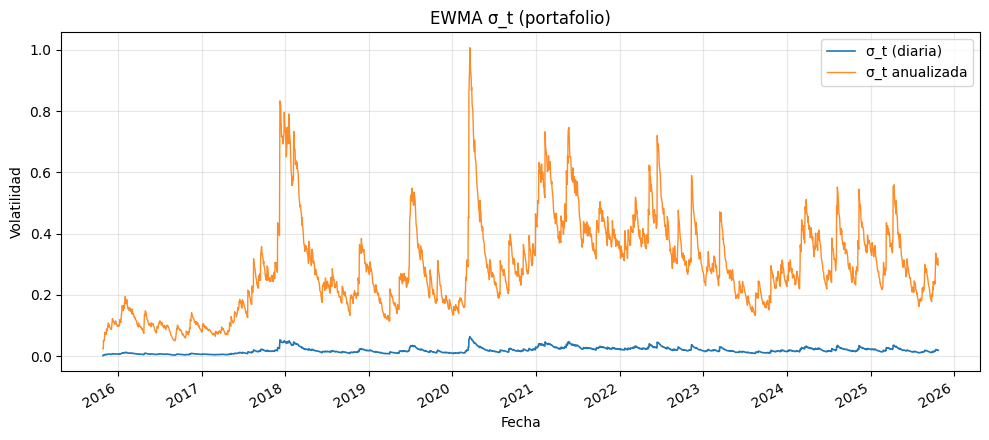


===== Estadísticas descriptivas del portafolio =====
count               :  2514.000000
mean                :  0.001363
std                 :  0.020861
var                 :  0.000435
min                 : -0.165990
p1                  : -0.059230
p5                  : -0.030259
p50                 :  0.001082
p95                 :  0.033472
p99                 :  0.060176
max                 :  0.136174
skew                : -0.199170
kurtosis            :  6.284017
kurtosis_excess     :  3.284017



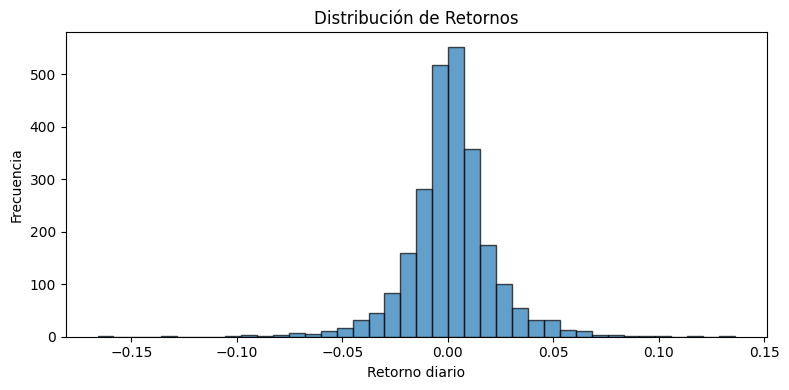


===== Test de Normalidad Jarque–Bera =====
Estadístico JB : 4133.4983
p-valor        : 0.000000
Conclusión     : Se rechaza H₀ — la distribución de retornos difiere significativamente de una Normal.



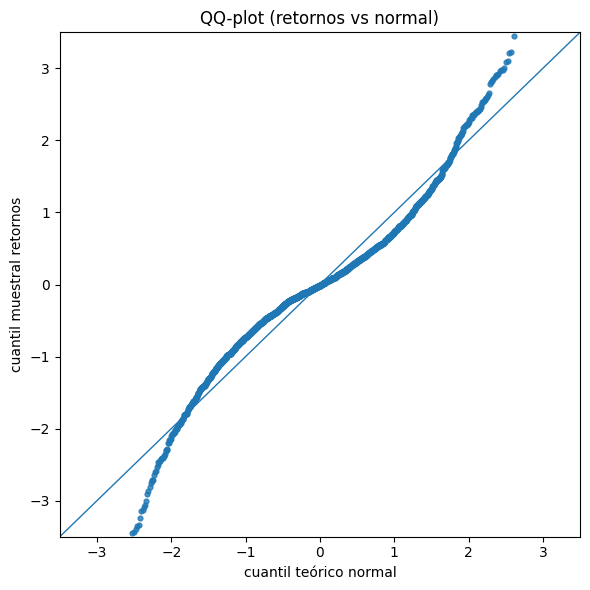

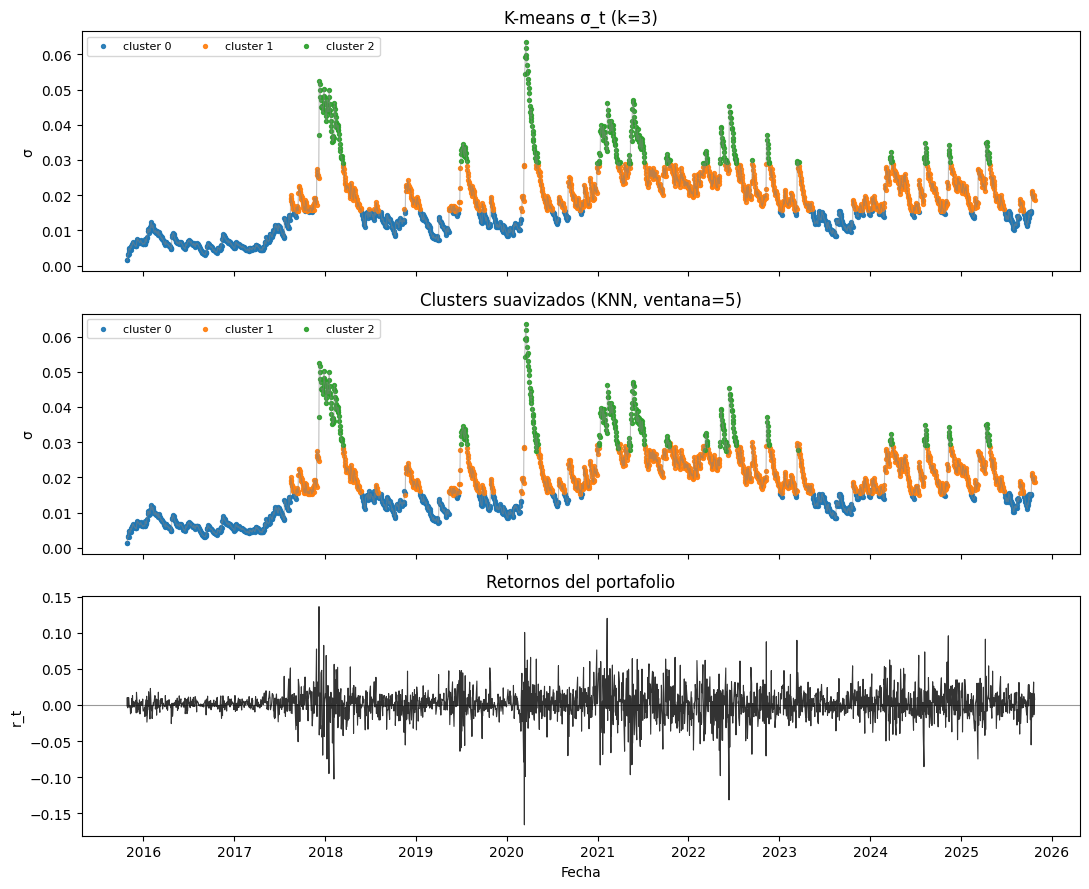


# Prueba de significancia de la media
- global: n=2514, mean=0.001363, std=0.020861, t=3.276, p=0.0011 -> significativa (p < 0.05)
- por estado (clusters_knn):
  · estado 0: n=1031, mean=0.001286, std=0.011618, t=3.554, p=0.0004 -> significativa (p < 0.05)
  · estado 1: n=1172, mean=0.001333, std=0.022469, t=2.030, p=0.0425 -> significativa (p < 0.05)
  · estado 2: n=311, mean=0.001735, std=0.034239, t=0.894, p=0.3722 -> no significativa (p ≥ 0.05)


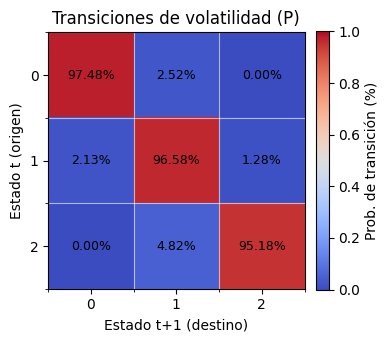

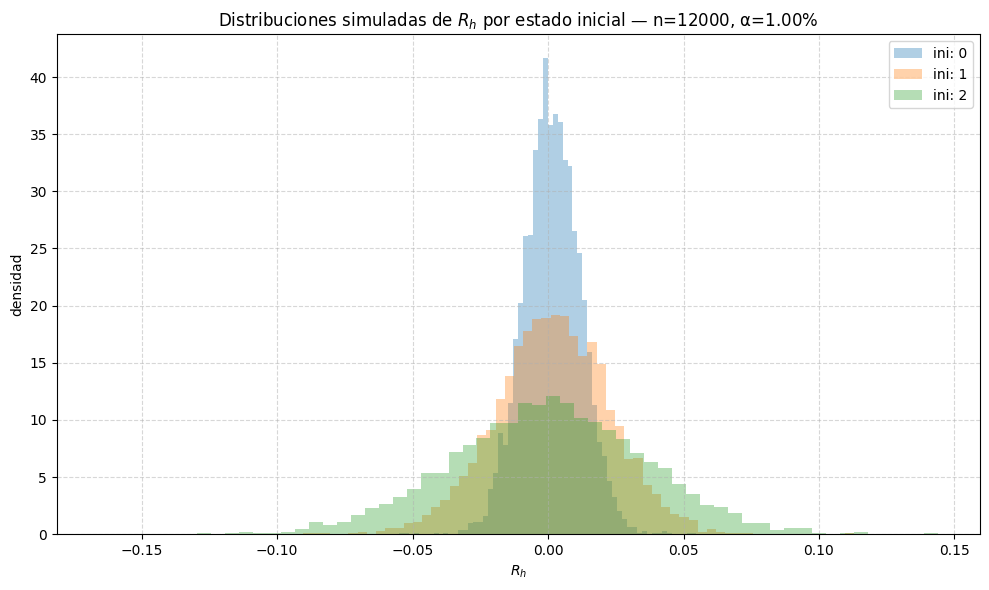


=== Resumen por estado “inicial” (t=1) ===
ini  0 | n=  4000  mean= 0.001446  std= 0.010614  VaR[1.00%]=-2.597112%  skew=-0.004  kur= 3.813  kur_ex= 0.813
ini  1 | n=  4000  mean= 0.001738  std= 0.021105  VaR[1.00%]=-5.019583%  skew=-0.076  kur= 3.387  kur_ex= 0.387
ini  2 | n=  4000  mean= 0.000054  std= 0.036039  VaR[1.00%]=-8.473792%  skew=-0.038  kur= 3.275  kur_ex= 0.275


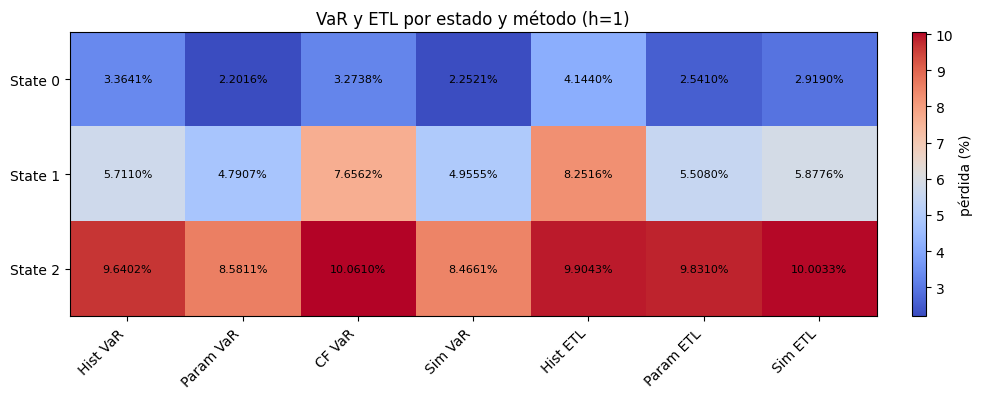

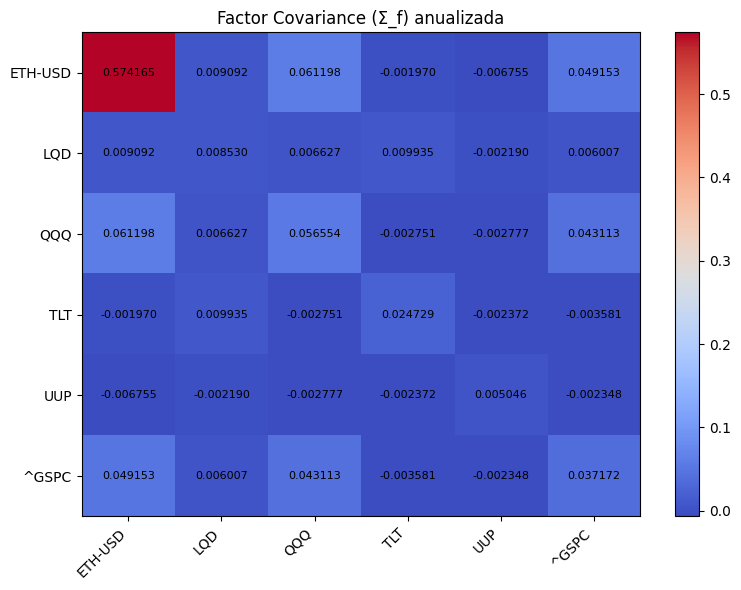

/tmp/ipython-input-3755944983.py:35: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  Ra = data["prices"].sort_index().pct_change().dropna(how="all")   # activos (T×N)


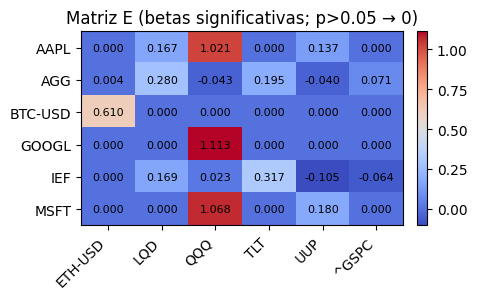

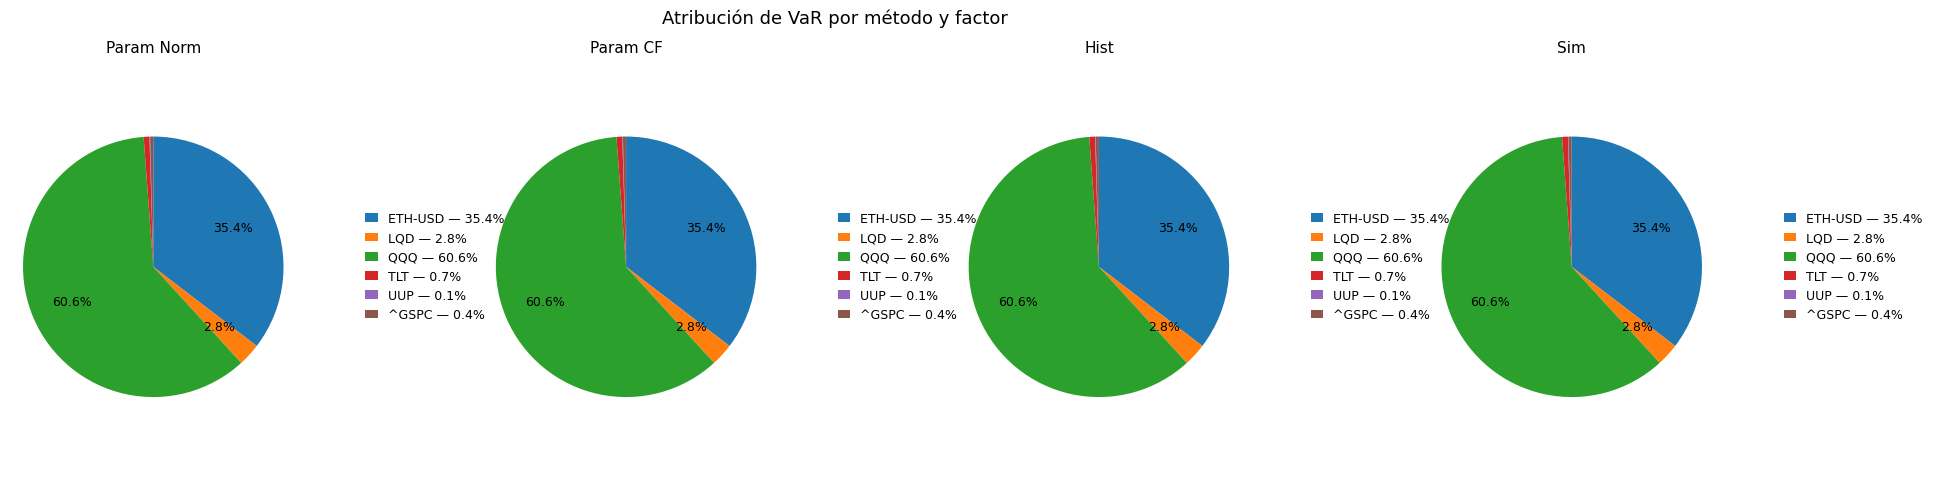

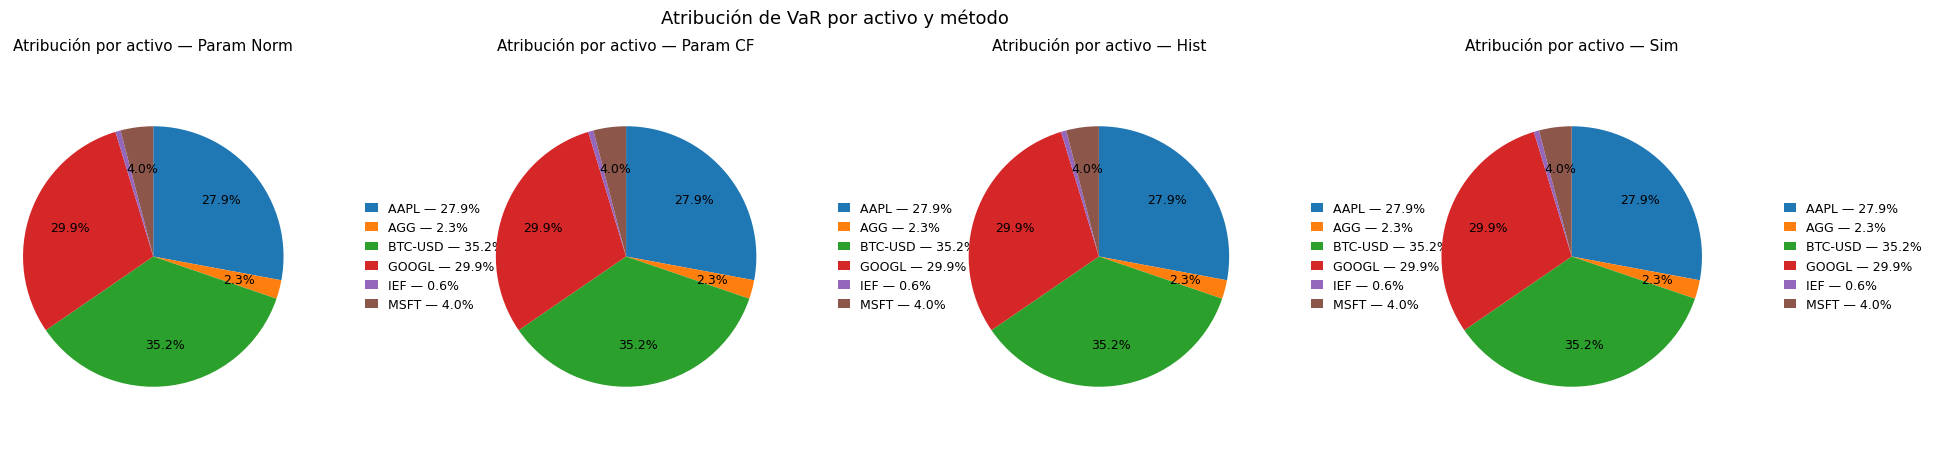

In [ ]:
# Acciones + Renta fija + FX + Crypto
data = {
    "tickers": [
        "AAPL","MSFT","GOOGL",
        "AGG","IEF",
        "BTC-USD"
    ],
    "weights": [0.21, 0.21, 0.17, 0.21, 0.17, 0.03],  # suma = 1.00
    "risk_factors": [
        "QQQ","TLT","LQD","UUP","^GSPC","ETH-USD"     # agrega factor cripto
    ],
    "period": "10y",
    "interval": "1d"
}


h1 = DownloadDataHandler()
h2 = PortfolioValueHandler()
h3 = CalculatePortfolioReturns()

# --- EWMA sobre retornos del portafolio ---
h4 = VolatilityEWMAHandler(
    lam=0.8,
    optimize_lambda=True,                # <- activa búsqueda de λ
    lam_grid=(0.60, 0.99, 0.01),         # <- grilla sugerida
    annualize=True,                      # <- también guarda σ anualizada
    title="EWMA σ_t (portafolio)"
)

h5 = DescriptiveStatsHandler()
h6 = PlotReturnsHistogramHandler(bins=40, title="Distribución de Retornos")
h7 = NormalityHandler()

# --- VaR paramétrico (Normal + Cornish-Fisher) usando σ_t de EWMA ---
h8 = VaRParamHandler(
    alpha=0.01,          # cola 1%
    horizon_days=1,      # horizonte h
    use_mean=False,      # μ=0 para diario
)

# --- VaR histórico con bootstrapping ---
h9 = VaRHistHandler(
    alpha=0.01,
    n_boot=1000,
    ci_level=0.95,
)

# --- ETL histórico simple ---
h10 = ETLHandler(
    alpha=0.01,
)

# --- K-means y KNN ---
h11 = VolatilityClusteringHandler(
    k=3,
    max_iter=1000#,
    #optimize_k=True
)

# --- t-test de la media (H0: μ = 0) ---
h12 = MeanSignificanceTestHandler(
    alpha=0.05,
)

# --- Markov (transiciones entre estados de volatilidad) ---
h13 = MarkovHandler(
    title="Transiciones de volatilidad (P)"   # el plot ahora siempre se muestra
    # opcionalmente: figsize=(8,8), cmap="coolwarm", annotate=True, decimals=3
)

# --- VaR simulado con Markov ---
h14 = SimuVaRHandler(
    start_mode="balanced",    # reparte n_sims entre estados
    n_sims=12000,
    horizon_days=1,
    alpha=0.01,
    alpha_sig=0.05,
)

# --- Histogramas de R_h por estado inicial (usando paths existentes) ---
h15 = PlotSimuByStartStateHandler(
    alpha=0.01,
    bins=60
)

h16 = StateConditionalRiskHandler(
    alpha=0.01,
    horizon_days=1,
    alpha_sig=0.05,
    cmap="coolwarm",
    decimals=4
)

h17 = FactorCovarianceHandler()

h18 = FactorBetasHandler()

h19 = GradVaRHandler()

h20 = VaRAttributionAllMethodsHandler()

h21 = InstrumentAttributionHandler()

# --- cadena ---

h1.set_next(h2).set_next(h3).set_next(h4).set_next(h5).set_next(h6)\
  .set_next(h7).set_next(h8).set_next(h9).set_next(h10).set_next(h11)\
  .set_next(h12).set_next(h13).set_next(h14).set_next(h15).set_next(h16)\
  .set_next(h17).set_next(h18).set_next(h19).set_next(h20).set_next(h21)

out = h1.handle(data)